<center><h1>Cai_Tufei_HW4</h1></center>
<br>
<br>

Name: Tufei Cai
<br>
Github Username: tufeitsai
<br>
USC ID: 1947878719

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.discrete.discrete_model import Logit
from sklearn . feature_selection import RFE
from statsmodels.tools import add_constant
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc
from scipy.stats import norm
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler

Get the AReM Data Set

In [2]:
bending1_ds1 = pd.read_csv('../data/bending1/dataset1.csv', skiprows = 4)
bending1_ds2 = pd.read_csv('../data/bending1/dataset2.csv',skiprows = 4)
bending1_df = pd.concat([bending1_ds1, bending1_ds2], ignore_index=True)
bending1_df['category'] = 'bending'
bending1_df.head(10)
bending1_df.shape

(960, 8)

In [3]:
bending2_ds1 = pd.read_csv('../data/bending2/dataset1.csv', skiprows = 4)
bending2_ds2 = pd.read_csv('../data/bending2/dataset2.csv',skiprows = 4)
bending2_df = pd.concat([bending2_ds1, bending2_ds2], ignore_index=True)
bending2_df['category'] = 'bending'
bending2_df.head(10)
bending2_df.shape

(960, 8)

### (b) Splitting Data

#### Test Data:

In [4]:
# datasets 1, 2, and 3 in other folders as test data and other datasets as train data.
# Folders for test data: cycling, lying, sitting, standing, walking
# Adding a category in order to make classification later on

def load_datasets(path, category_name, dataset_nums):
    dfs = []
    for dataset_num in dataset_nums:
        file_path = f"{path}/dataset{dataset_num}.csv"
        df = pd.read_csv(file_path, skiprows=4)
        df['category'] = category_name
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

paths_and_categories = {
    '../data/cycling': 'cycling',
    '../data/lying': 'lying',
    '../data/sitting': 'sitting',
    '../data/standing': 'standing',
    '../data/walking': 'walking'
}


test_dfs = []
for path, category_name in paths_and_categories.items():
    test_dfs.append(load_datasets(path, category_name, range(1, 4)))

df_test = pd.concat(test_dfs, ignore_index=True)
df_test = pd.concat([df_test,bending1_df,bending2_df])

In [5]:
df_test.shape # 19 * 480

(9120, 8)

In [6]:
df_test.head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,category
0,0,32.0,4.85,17.50,3.35,22.50,3.20,cycling
1,250,40.5,1.12,14.00,2.24,21.75,1.30,cycling
2,500,40.5,2.60,11.33,4.50,18.25,5.31,cycling
3,750,34.5,1.50,20.67,2.87,19.00,2.83,cycling
4,1000,34.5,1.50,21.25,3.27,18.25,4.38,cycling


In [7]:
df_test.isnull().sum()

# Columns: time    0
avg_rss12          0
var_rss12          0
avg_rss13          0
var_rss13          0
avg_rss23          0
var_rss23          0
category           0
dtype: int64

#### Train Data

In [8]:
# The dataset4 in bending 2 is seperated by space, now coverted it to comma
'''
import csv

input_file = "../data/bending2/dataset4.csv"
output_file = "../data/bending2/new.csv"

with open(input_file, 'r', newline='') as infile, open(output_file, 'w', newline='') as outfile:
    reader = csv.reader(infile, delimiter=' ')
    writer = csv.writer(outfile, delimiter=',')
    for row in reader:
        writer.writerow(row)
'''

'\nimport csv\n\ninput_file = "../data/bending2/dataset4.csv"\noutput_file = "../data/bending2/new.csv"\n\nwith open(input_file, \'r\', newline=\'\') as infile, open(output_file, \'w\', newline=\'\') as outfile:\n    reader = csv.reader(infile, delimiter=\' \')\n    writer = csv.writer(outfile, delimiter=\',\')\n    for row in reader:\n        writer.writerow(row)\n'

In [9]:
# bending1: 3-7
# beding2: 3-6
# cycling: 4-15
# lying: 4-15
# sitting: 4-15
# standing: 4-15
# walking: 4-15

# The previous i forgot to add the category of each instances
# Now i will add the category in order to do the classification

def load_train_datasets(path, category_name, dataset_nums):
    train_dfs = []
    for dataset_num in dataset_nums:
        file_path = f"{path}/dataset{dataset_num}.csv"
        df = pd.read_csv(file_path, skiprows=4)
        df['category'] = category_name 
        train_dfs.append(df)
    return pd.concat(train_dfs, ignore_index=True)

train_paths_and_categories = {
    '../data/bending1': ('bending', range(3, 8)),
    '../data/bending2': ('bending', range(3, 7)),
    '../data/cycling': ('cycling', range(4, 16)),
    '../data/lying': ('lying', range(4, 16)),
    '../data/sitting': ('sitting', range(4, 16)),
    '../data/standing': ('standing', range(4, 16)),
    '../data/walking': ('walking', range(4, 16))
}


train_dfs = []
for path, (category_name, dataset_nums) in train_paths_and_categories.items():
    train_dfs.append(load_train_datasets(path, category_name, dataset_nums))


df_train = pd.concat(train_dfs, ignore_index=True)


In [10]:
df_train.shape # 69 x 480

(33119, 8)

In [11]:
df_train.head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,category
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending


In [12]:
df_train.isnull().sum()

# Columns: time    0
avg_rss12          0
var_rss12          0
avg_rss13          0
var_rss13          0
avg_rss23          0
var_rss23          0
category           0
dtype: int64

### (c) Feature Extraction

#### i. Research

**Types of time-domain features in time seires:**

- Mean
- Median
- Standard Deviation
- Variance
- Minimum
- Maximum
- Range
- Kurtosis : A measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution
- Absolute Mean: The average of the absolute values of the data points
- Interquartile Range(IQR)

#### ii. Extraction

In [13]:
# bending1
bending1_features = []

bending1_path = '../data/bending1'

for dataset_num in range(1, 8):
    file_path = f"{bending1_path}/dataset{dataset_num}.csv"

    df = pd.read_csv(file_path, skiprows=4).drop('# Columns: time', axis=1)
    
    df_features = {
        'Instance': f'{dataset_num}'
    }
    for i, column in enumerate(df.columns, start=1):
        df_features[f'min_{i}'] = df[column].min()
        df_features[f'max_{i}'] = df[column].max()
        df_features[f'mean_{i}'] = df[column].mean()
        df_features[f'median_{i}'] = df[column].median()
        df_features[f'1st_quart_{i}'] = df[column].quantile(0.25)
        df_features[f'3rd_quart_{i}'] = df[column].quantile(0.75)
    
    bending1_features.append(df_features)
    
bending1_extract = pd.DataFrame(bending1_features)
columns = ['Instance'] + [col for col in bending1_extract if col != 'Instance']
bending1_extract = bending1_extract[columns]


# bending2
bending2_features = []

bending2_path = '../data/bending2'

for dataset_num in range(1, 7):
    file_path = f"{bending2_path}/dataset{dataset_num}.csv"

    df = pd.read_csv(file_path, skiprows=4).drop('# Columns: time', axis=1)
    
    df_features = {
        'Instance': f'{dataset_num}'
    }
    for i, column in enumerate(df.columns, start=1):
        df_features[f'min_{i}'] = df[column].min()
        df_features[f'max_{i}'] = df[column].max()
        df_features[f'mean_{i}'] = df[column].mean()
        df_features[f'median_{i}'] = df[column].median()
        df_features[f'1st_quart_{i}'] = df[column].quantile(0.25)
        df_features[f'3rd_quart_{i}'] = df[column].quantile(0.75)
    
    bending2_features.append(df_features)
    
bending2_extract = pd.DataFrame(bending2_features)
columns = ['Instance'] + [col for col in bending2_extract if col != 'Instance']
bending2_extract = bending2_extract[columns]


# cycling
cycling_path = '../data/cycling'
cycling_features = []

for dataset_num in range(1, 16):
    file_path = f"{cycling_path}/dataset{dataset_num}.csv"

    df = pd.read_csv(file_path, skiprows=4).drop('# Columns: time', axis=1)
    
    df_features = {
        'Instance': f'{dataset_num}'
    }
    for i, column in enumerate(df.columns, start=1):
        df_features[f'min_{i}'] = df[column].min()
        df_features[f'max_{i}'] = df[column].max()
        df_features[f'mean_{i}'] = df[column].mean()
        df_features[f'median_{i}'] = df[column].median()
        df_features[f'1st_quart_{i}'] = df[column].quantile(0.25)
        df_features[f'3rd_quart_{i}'] = df[column].quantile(0.75)
    
    cycling_features.append(df_features)
    
cycling_extract = pd.DataFrame(cycling_features)
columns = ['Instance'] + [col for col in cycling_extract if col != 'Instance']
cycling_extract = cycling_extract[columns]

# lying
lying_path = '../data/lying'
lying_features = []

for dataset_num in range(1, 16):
    file_path = f"{lying_path}/dataset{dataset_num}.csv"

    df = pd.read_csv(file_path, skiprows=4).drop('# Columns: time', axis=1)
    
    df_features = {
        'Instance': f'{dataset_num}'
    }
    for i, column in enumerate(df.columns, start=1):
        df_features[f'min_{i}'] = df[column].min()
        df_features[f'max_{i}'] = df[column].max()
        df_features[f'mean_{i}'] = df[column].mean()
        df_features[f'median_{i}'] = df[column].median()
        df_features[f'1st_quart_{i}'] = df[column].quantile(0.25)
        df_features[f'3rd_quart_{i}'] = df[column].quantile(0.75)
    
    lying_features.append(df_features)
    
lying_extract = pd.DataFrame(lying_features)
columns = ['Instance'] + [col for col in lying_extract if col != 'Instance']
lying_extract = lying_extract[columns]


# Sitting
sitting_path = '../data/sitting'
sitting_features = []

for dataset_num in range(1, 16):
    file_path = f"{sitting_path}/dataset{dataset_num}.csv"

    df = pd.read_csv(file_path, skiprows=4).drop('# Columns: time', axis=1)
    
    df_features = {
        'Instance': f'{dataset_num}'
    }
    for i, column in enumerate(df.columns, start=1):
        df_features[f'min_{i}'] = df[column].min()
        df_features[f'max_{i}'] = df[column].max()
        df_features[f'mean_{i}'] = df[column].mean()
        df_features[f'median_{i}'] = df[column].median()
        df_features[f'1st_quart_{i}'] = df[column].quantile(0.25)
        df_features[f'3rd_quart_{i}'] = df[column].quantile(0.75)
    
    sitting_features.append(df_features)
    
sitting_extract = pd.DataFrame(sitting_features)
columns = ['Instance'] + [col for col in sitting_extract if col != 'Instance']
sitting_extract = sitting_extract[columns]


# standing
standing_path = '../data/standing'
standing_features = []

for dataset_num in range(1, 16):
    file_path = f"{standing_path}/dataset{dataset_num}.csv"

    df = pd.read_csv(file_path, skiprows=4).drop('# Columns: time', axis=1)
    
    df_features = {
        'Instance': f'{dataset_num}'
    }
    for i, column in enumerate(df.columns, start=1):
        df_features[f'min_{i}'] = df[column].min()
        df_features[f'max_{i}'] = df[column].max()
        df_features[f'mean_{i}'] = df[column].mean()
        df_features[f'median_{i}'] = df[column].median()
        df_features[f'1st_quart_{i}'] = df[column].quantile(0.25)
        df_features[f'3rd_quart_{i}'] = df[column].quantile(0.75)
    
    standing_features.append(df_features)
    
standing_extract = pd.DataFrame(standing_features)
columns = ['Instance'] + [col for col in standing_extract if col != 'Instance']
standing_extract = standing_extract[columns]

# walking
walking_path = '../data/walking'
walking_features = []

for dataset_num in range(1, 16):
    file_path = f"{walking_path}/dataset{dataset_num}.csv"

    df = pd.read_csv(file_path, skiprows=4).drop('# Columns: time', axis=1)
    
    df_features = {
        'Instance': f'{dataset_num}'
    }
    for i, column in enumerate(df.columns, start=1):
        df_features[f'min_{i}'] = df[column].min()
        df_features[f'max_{i}'] = df[column].max()
        df_features[f'mean_{i}'] = df[column].mean()
        df_features[f'median_{i}'] = df[column].median()
        df_features[f'1st_quart_{i}'] = df[column].quantile(0.25)
        df_features[f'3rd_quart_{i}'] = df[column].quantile(0.75)
    
    walking_features.append(df_features)
    
walking_extract = pd.DataFrame(walking_features)
columns = ['Instance'] + [col for col in walking_extract if col != 'Instance']
walking_extract = walking_extract[columns]

In [14]:
extract_datasets = [bending1_extract, bending2_extract, cycling_extract, lying_extract, sitting_extract, standing_extract, walking_extract]

combined_df = pd.DataFrame()

instance_counter = 1

for df in extract_datasets:
    df['Instance'] = range(instance_counter, instance_counter + len(df))
    instance_counter += len(df)
    combined_df = pd.concat([combined_df, df], ignore_index=True)


cols = ['Instance'] + [col for col in combined_df.columns if col != 'Instance']
combined_df = combined_df[cols]
combined_df.set_index('Instance', inplace=True)

In [15]:
combined_df

,min_1,max_1,mean_1,median_1,1st_quart_1,3rd_quart_1,min_2,max_2,mean_2,median_2,...,mean_5,median_5,1st_quart_5,3rd_quart_5,min_6,max_6,mean_6,median_6,1st_quart_6,3rd_quart_6
Instance,,,,,,,,,,,,,,,,,,,,,
1,37.25,45.00,40.624792,40.50,39.25,42.0000,0.0,1.30,0.358604,0.430,...,34.311292,35.00,33.0000,36.00,0.00,1.92,0.570583,0.43,0.0000,1.3000
2,38.00,45.67,42.812812,42.50,42.00,43.6700,0.0,1.22,0.372438,0.470,...,33.024583,33.00,32.0000,34.50,0.00,3.11,0.571083,0.43,0.0000,1.3000
3,35.00,47.40,43.954500,44.33,43.00,45.0000,0.0,1.70,0.426250,0.470,...,35.588458,36.00,35.3625,36.50,0.00,1.79,0.493292,0.43,0.0000,0.9400
4,33.00,47.75,42.179813,43.50,39.15,45.0000,0.0,3.00,0.696042,0.500,...,33.493917,35.00,30.4575,36.33,0.00,2.18,0.613521,0.50,0.0000,1.0000
5,33.00,45.75,41.678063,41.75,41.33,42.7500,0.0,2.83,0.535979,0.500,...,29.857083,30.00,28.4575,31.25,0.00,1.79,0.383292,0.43,0.0000,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,19.50,45.33,33.586875,34.25,30.25,37.0000,0.0,14.67,4.576562,4.260,...,15.892146,16.00,13.7300,18.25,0.00,8.32,3.259729,3.11,2.0500,4.3225
85,19.75,45.50,34.322750,35.25,31.00,38.0000,0.0,13.47,4.456333,3.900,...,15.550458,15.75,13.5000,17.75,0.00,9.67,3.432562,3.20,2.1575,4.5650
86,19.50,46.00,34.546229,35.25,31.25,37.8125,0.0,12.47,4.371958,4.135,...,15.759542,15.75,14.0000,17.75,0.00,10.00,3.338125,3.08,2.1600,4.3350


In [16]:
combined_df.describe()

,min_1,max_1,mean_1,median_1,1st_quart_1,3rd_quart_1,min_2,max_2,mean_2,median_2,...,mean_5,median_5,1st_quart_5,3rd_quart_5,min_6,max_6,mean_6,median_6,1st_quart_6,3rd_quart_6
count,88.000000,88.000000,88.000000,88.000000,88.00000,88.000000,88.0,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.00000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,29.036705,45.473068,38.917357,38.856705,37.01983,41.197216,0.0,6.290114,1.459119,1.288068,...,16.035170,16.239602,13.826761,18.52821,0.004886,6.461932,1.620686,1.445511,0.902017,2.142614
std,9.569975,4.394362,5.335718,5.440054,6.15359,5.138925,0.0,5.062729,1.574164,1.412244,...,5.675593,5.813782,6.096465,5.53172,0.045838,2.518921,1.154812,1.086474,0.758584,1.523599
min,0.000000,30.000000,24.562958,24.250000,23.18750,26.500000,0.0,0.430000,0.007167,0.000000,...,4.303979,2.250000,1.000000,5.54250,0.000000,1.790000,0.383292,0.430000,0.000000,0.500000
25%,21.875000,44.585000,34.845755,35.447500,31.62750,38.250000,0.0,1.767500,0.366630,0.430000,...,13.390958,13.447500,11.295000,16.64250,0.000000,4.500000,0.730656,0.500000,0.430000,1.000000
50%,28.625000,45.750000,39.433792,39.415000,39.20000,40.250000,0.0,4.500000,0.489365,0.500000,...,15.993198,16.125000,14.000000,18.28125,0.000000,6.310000,0.930188,0.830000,0.470000,1.220000
75%,36.270000,47.750000,43.013250,43.250000,42.00000,45.000000,0.0,10.930000,2.731505,2.185000,...,17.376687,17.812500,15.500000,20.75000,0.000000,8.765000,3.005229,2.615000,1.670000,4.043125
max,48.000000,56.250000,48.004167,48.000000,48.00000,54.000000,0.0,17.240000,4.576562,4.260000,...,35.588458,36.000000,35.362500,36.50000,0.430000,13.610000,3.530500,3.340000,2.240000,4.617500


## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

In [17]:
df_train.head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,category
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending


#### i. Plots

In [18]:
# Time series 1, 2, 6 
# avg_rss12, var_rss12, var_rss23

# 3 features: Min, Max, Mean


# Label 'bending' as 0 and others as 1
df_train_bending = df_train
df_train_bending['label'] = df_train_bending['category'].apply(lambda x: 0 if x == 'bending' else 1)

df_train_bending = df_train_bending[['avg_rss12','var_rss12','var_rss23','label']]

# 0 as bending, 1 as others

df_train_bending

,avg_rss12,var_rss12,var_rss23,label
0,42.00,0.71,0.00,0
1,41.50,0.50,1.09,0
2,41.50,0.50,0.00,0
3,40.75,0.83,0.00,0
4,40.00,0.71,0.43,0
...,...,...,...,...
33114,34.50,6.18,4.19,1
33115,25.75,6.02,1.58,1
33116,31.50,3.35,2.95,1
33117,33.75,2.77,0.43,1


In [19]:
df_train_bending = df_train_bending.copy()

# Seems we are comparing bending and all others, thus we do not need to cover the missing row in the sitting
num_rows_per_instance = 480
last_instance_rows = 479

num_instances = len(df_train_bending) // num_rows_per_instance

df_train_bending['instance'] = 0

start_row = 0
for i in range(num_instances):
    end_row = start_row + num_rows_per_instance
    df_train_bending.loc[start_row:end_row, 'instance'] = i + 1
    start_row = end_row

df_train_bending.loc[start_row:start_row + last_instance_rows, 'instance'] = num_instances + 1

grouped = df_train_bending.groupby('instance')
min_max_mean_df = grouped[['avg_rss12', 'var_rss12', 'var_rss23']].agg(['min', 'max', 'mean']).reset_index()

min_max_mean_df.columns = ['_'.join(col).strip() for col in min_max_mean_df.columns.values]

min_max_mean_df['label'] = grouped['label'].first().values

min_max_mean_df

,instance_,avg_rss12_min,avg_rss12_max,avg_rss12_mean,var_rss12_min,var_rss12_max,var_rss12_mean,var_rss23_min,var_rss23_max,var_rss23_mean,label
0,1,35.00,47.40,43.954500,0.0,1.70,0.426250,0.00,1.79,0.493292,0
1,2,33.00,47.75,42.179813,0.0,3.00,0.696042,0.00,2.18,0.613521,0
2,3,33.00,45.75,41.678063,0.0,2.83,0.535979,0.00,1.79,0.383292,0
3,4,37.00,48.00,43.454958,0.0,1.58,0.378083,0.00,5.26,0.679646,0
4,5,36.25,48.00,43.969125,0.0,1.50,0.413125,0.00,2.96,0.555312,0
...,...,...,...,...,...,...,...,...,...,...,...
64,65,19.50,45.33,33.560667,0.0,14.67,4.570375,0.00,8.32,3.259042,1
65,66,19.75,45.50,34.330562,0.0,13.47,4.461417,0.00,9.67,3.438563,1
66,67,19.50,46.00,34.542063,0.0,12.47,4.373833,0.00,10.00,3.337250,1
67,68,23.50,46.25,34.886250,0.0,14.82,4.391333,0.00,9.51,3.424187,1


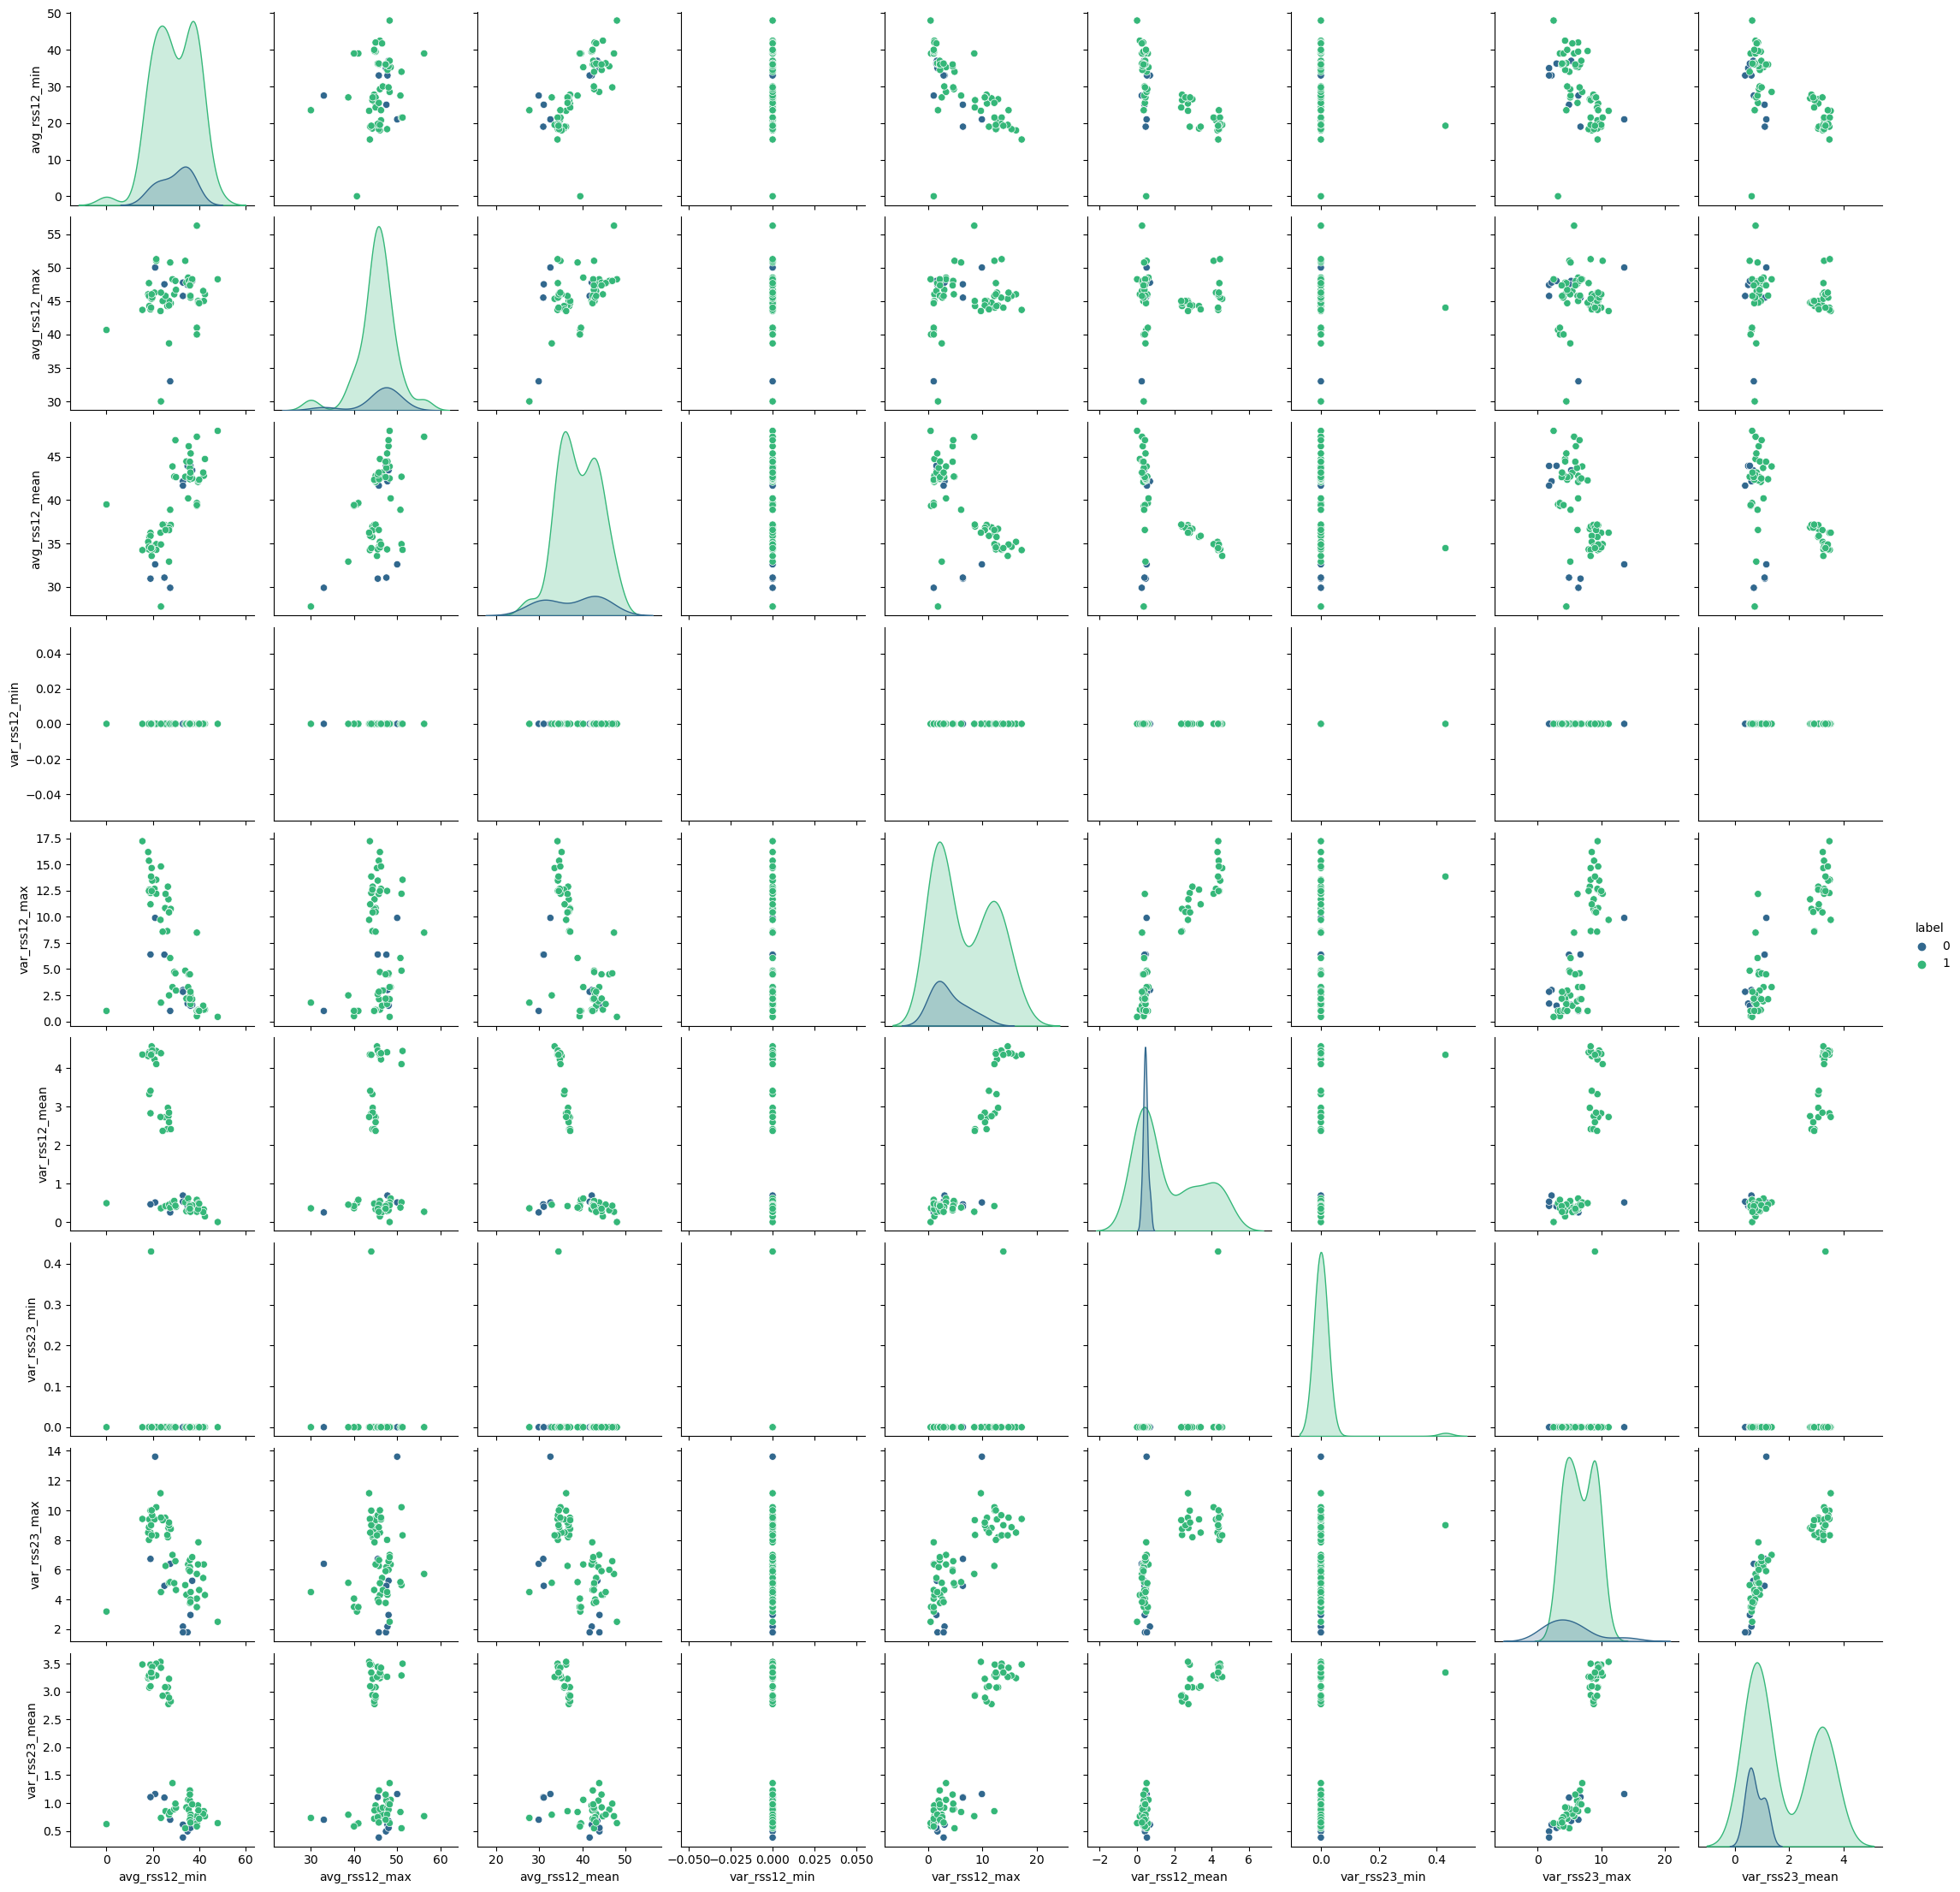

In [20]:
columns_to_plot = ['avg_rss12_min', 'avg_rss12_max', 'avg_rss12_mean', 
                   'var_rss12_min', 'var_rss12_max', 'var_rss12_mean', 
                   'var_rss23_min', 'var_rss23_max', 'var_rss23_mean']

pairplot = sns.pairplot(min_max_mean_df, vars=columns_to_plot, hue='label', palette='viridis')
plt.show()

#### ii. Splitted Plots

In [21]:
df_train_ii = df_train
df_train_ii['label'] = df_train_ii['category'].apply(lambda x: 0 if x == 'bending' else 1)

In [22]:
df_train_ii

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,category,label
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending,0
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending,0
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending,0
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending,0
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending,0
...,...,...,...,...,...,...,...,...,...
33114,118750,34.50,6.18,9.00,3.56,12.67,4.19,walking,1
33115,119000,25.75,6.02,13.75,2.05,16.00,1.58,walking,1
33116,119250,31.50,3.35,10.25,5.12,16.25,2.95,walking,1
33117,119500,33.75,2.77,14.00,3.24,13.75,0.43,walking,1


In [23]:
# 480 rows as one instance
instance_length = 480 

stats_list = []
instance_counter = 0

for start in range(0, len(df_train_ii), instance_length):
    instance_counter += 1 # count for which instance
    end = start + instance_length
    end = min(end, len(df_train_ii))
    
    label = df_train_ii.iloc[start]['label'] # 0 as bending, 1 as others
    
    part1 = df_train_ii.iloc[start:start + instance_length // 2]
    part2 = df_train_ii.iloc[start + instance_length // 2:end]

    for part, part_name in [(part1, "part1"), (part2, "part2")]:
        stats = {
            'instance': instance_counter,
            'part': part_name,
            'label': label,
            'avg_rss12_min': part['avg_rss12'].min(), # avg_rss12
            'avg_rss12_max': part['avg_rss12'].max(),
            'avg_rss12_mean': part['avg_rss12'].mean(),
            'var_rss12_min': part['var_rss12'].min(), # var_rss12
            'var_rss12_max': part['var_rss12'].max(),
            'var_rss12_mean': part['var_rss12'].mean(),
            'avg_rss13_min':part['avg_rss13'].min(), # avg_rss13
            'avg_rss13_max':part['avg_rss13'].max(),
            'avg_rss13_mean':part['avg_rss13'].mean(),
            'var_rss13_min':part['var_rss13'].min(), # var_rss13
            'var_rss13_max':part['var_rss13'].max(),
            'var_rss13_mean':part['var_rss13'].mean(),
            'avg_rss23_min': part['avg_rss23'].min(), # avg_rss23
            'avg_rss23_max': part['avg_rss23'].max(),
            'avg_rss23_mean': part['avg_rss23'].mean(),
            'var_rss23_min': part['var_rss23'].min(), # var_rss23
            'var_rss23_max': part['var_rss23'].max(),
            'var_rss23_mean': part['var_rss23'].mean(),
        }
        stats_list.append(stats)

stats_df = pd.DataFrame(stats_list)
stats_df

,instance,part,label,avg_rss12_min,avg_rss12_max,avg_rss12_mean,var_rss12_min,var_rss12_max,var_rss12_mean,avg_rss13_min,...,avg_rss13_mean,var_rss13_min,var_rss13_max,var_rss13_mean,avg_rss23_min,avg_rss23_max,avg_rss23_mean,var_rss23_min,var_rss23_max,var_rss23_mean
0,1,part1,0,36.50,46.50,44.057167,0.00,1.50,0.381042,14.25,...,23.096792,0.00,2.74,0.493458,30.00,38.50,36.293542,0.00,1.79,0.598250
1,1,part2,0,35.00,47.40,43.851833,0.00,1.70,0.471458,6.50,...,21.147917,0.00,4.44,0.501167,29.00,38.25,34.883375,0.00,1.50,0.388333
2,2,part1,0,33.75,47.75,43.278875,0.00,3.00,0.673292,11.00,...,23.141250,0.00,4.77,0.808042,30.75,38.67,36.022125,0.00,1.53,0.640958
3,2,part2,0,33.00,46.00,41.080750,0.00,2.86,0.718792,8.50,...,21.226000,0.00,5.15,1.171792,20.00,38.50,30.965708,0.00,2.18,0.586083
4,3,part1,0,33.00,45.75,41.621208,0.00,2.83,0.623083,3.00,...,19.081458,0.00,6.42,1.115083,23.67,37.50,30.078333,0.00,1.79,0.419083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,67,part2,1,20.25,46.00,35.050250,0.00,12.28,4.178750,7.67,...,15.037292,0.00,8.22,3.041500,7.00,21.33,15.201750,0.00,8.64,3.451292
134,68,part1,1,24.33,44.00,34.924958,0.00,14.82,4.191792,6.67,...,15.519000,0.00,8.34,3.227375,6.00,23.50,15.780250,0.00,9.18,3.440917
135,68,part2,1,23.50,46.25,34.847542,0.43,12.26,4.590875,8.75,...,15.430667,0.47,9.90,3.195583,5.50,23.50,15.967542,0.00,9.51,3.407458
136,69,part1,1,19.25,44.00,34.916458,0.00,13.86,4.230333,6.00,...,15.339417,0.00,9.10,3.230125,4.67,23.00,15.753542,0.43,9.00,3.447292


In [24]:
part1_df = stats_df[stats_df['part'] == 'part1'].reset_index(drop=True)
part2_df = stats_df[stats_df['part'] == 'part2'].reset_index(drop=True)

# seems we focues on the time series feature 1, 2, 6
#time_series_features = ['avg_rss12_min','avg_rss12_max','avg_rss12_mean','var_rss12_min','var_rss12_max','var_rss12_mean','var_rss23_min','var_rss23_max','var_rss23_mean']

#part1_df = part1_df[time_series_features]
#part2_df = part2_df[time_series_features]

In [25]:
part1_df

,instance,part,label,avg_rss12_min,avg_rss12_max,avg_rss12_mean,var_rss12_min,var_rss12_max,var_rss12_mean,avg_rss13_min,...,avg_rss13_mean,var_rss13_min,var_rss13_max,var_rss13_mean,avg_rss23_min,avg_rss23_max,avg_rss23_mean,var_rss23_min,var_rss23_max,var_rss23_mean
0,1,part1,0,36.50,46.50,44.057167,0.0,1.50,0.381042,14.25,...,23.096792,0.00,2.74,0.493458,30.00,38.50,36.293542,0.00,1.79,0.598250
1,2,part1,0,33.75,47.75,43.278875,0.0,3.00,0.673292,11.00,...,23.141250,0.00,4.77,0.808042,30.75,38.67,36.022125,0.00,1.53,0.640958
2,3,part1,0,33.00,45.75,41.621208,0.0,2.83,0.623083,3.00,...,19.081458,0.00,6.42,1.115083,23.67,37.50,30.078333,0.00,1.79,0.419083
3,4,part1,0,39.00,48.00,44.117042,0.0,1.30,0.250042,6.25,...,17.744167,0.00,10.03,1.123000,10.00,33.50,23.218708,0.00,5.26,0.815417
4,5,part1,0,36.67,45.00,43.486208,0.0,1.30,0.378667,4.00,...,16.397250,0.00,5.17,0.662958,11.33,30.75,22.325458,0.00,2.28,0.524875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,part1,1,19.50,45.00,33.298750,0.0,11.78,4.407542,7.33,...,15.431792,0.00,8.79,3.279917,8.00,25.00,16.043958,0.00,8.29,3.225125
65,66,part1,1,20.33,44.50,34.040917,0.0,13.47,4.781917,6.25,...,15.160417,0.43,9.00,3.387875,6.25,22.75,15.572208,0.47,8.41,3.549000
66,67,part1,1,19.50,43.33,34.033875,0.0,12.47,4.568917,7.00,...,15.326875,0.00,8.34,3.011167,7.00,22.75,16.329833,0.00,10.00,3.223208
67,68,part1,1,24.33,44.00,34.924958,0.0,14.82,4.191792,6.67,...,15.519000,0.00,8.34,3.227375,6.00,23.50,15.780250,0.00,9.18,3.440917


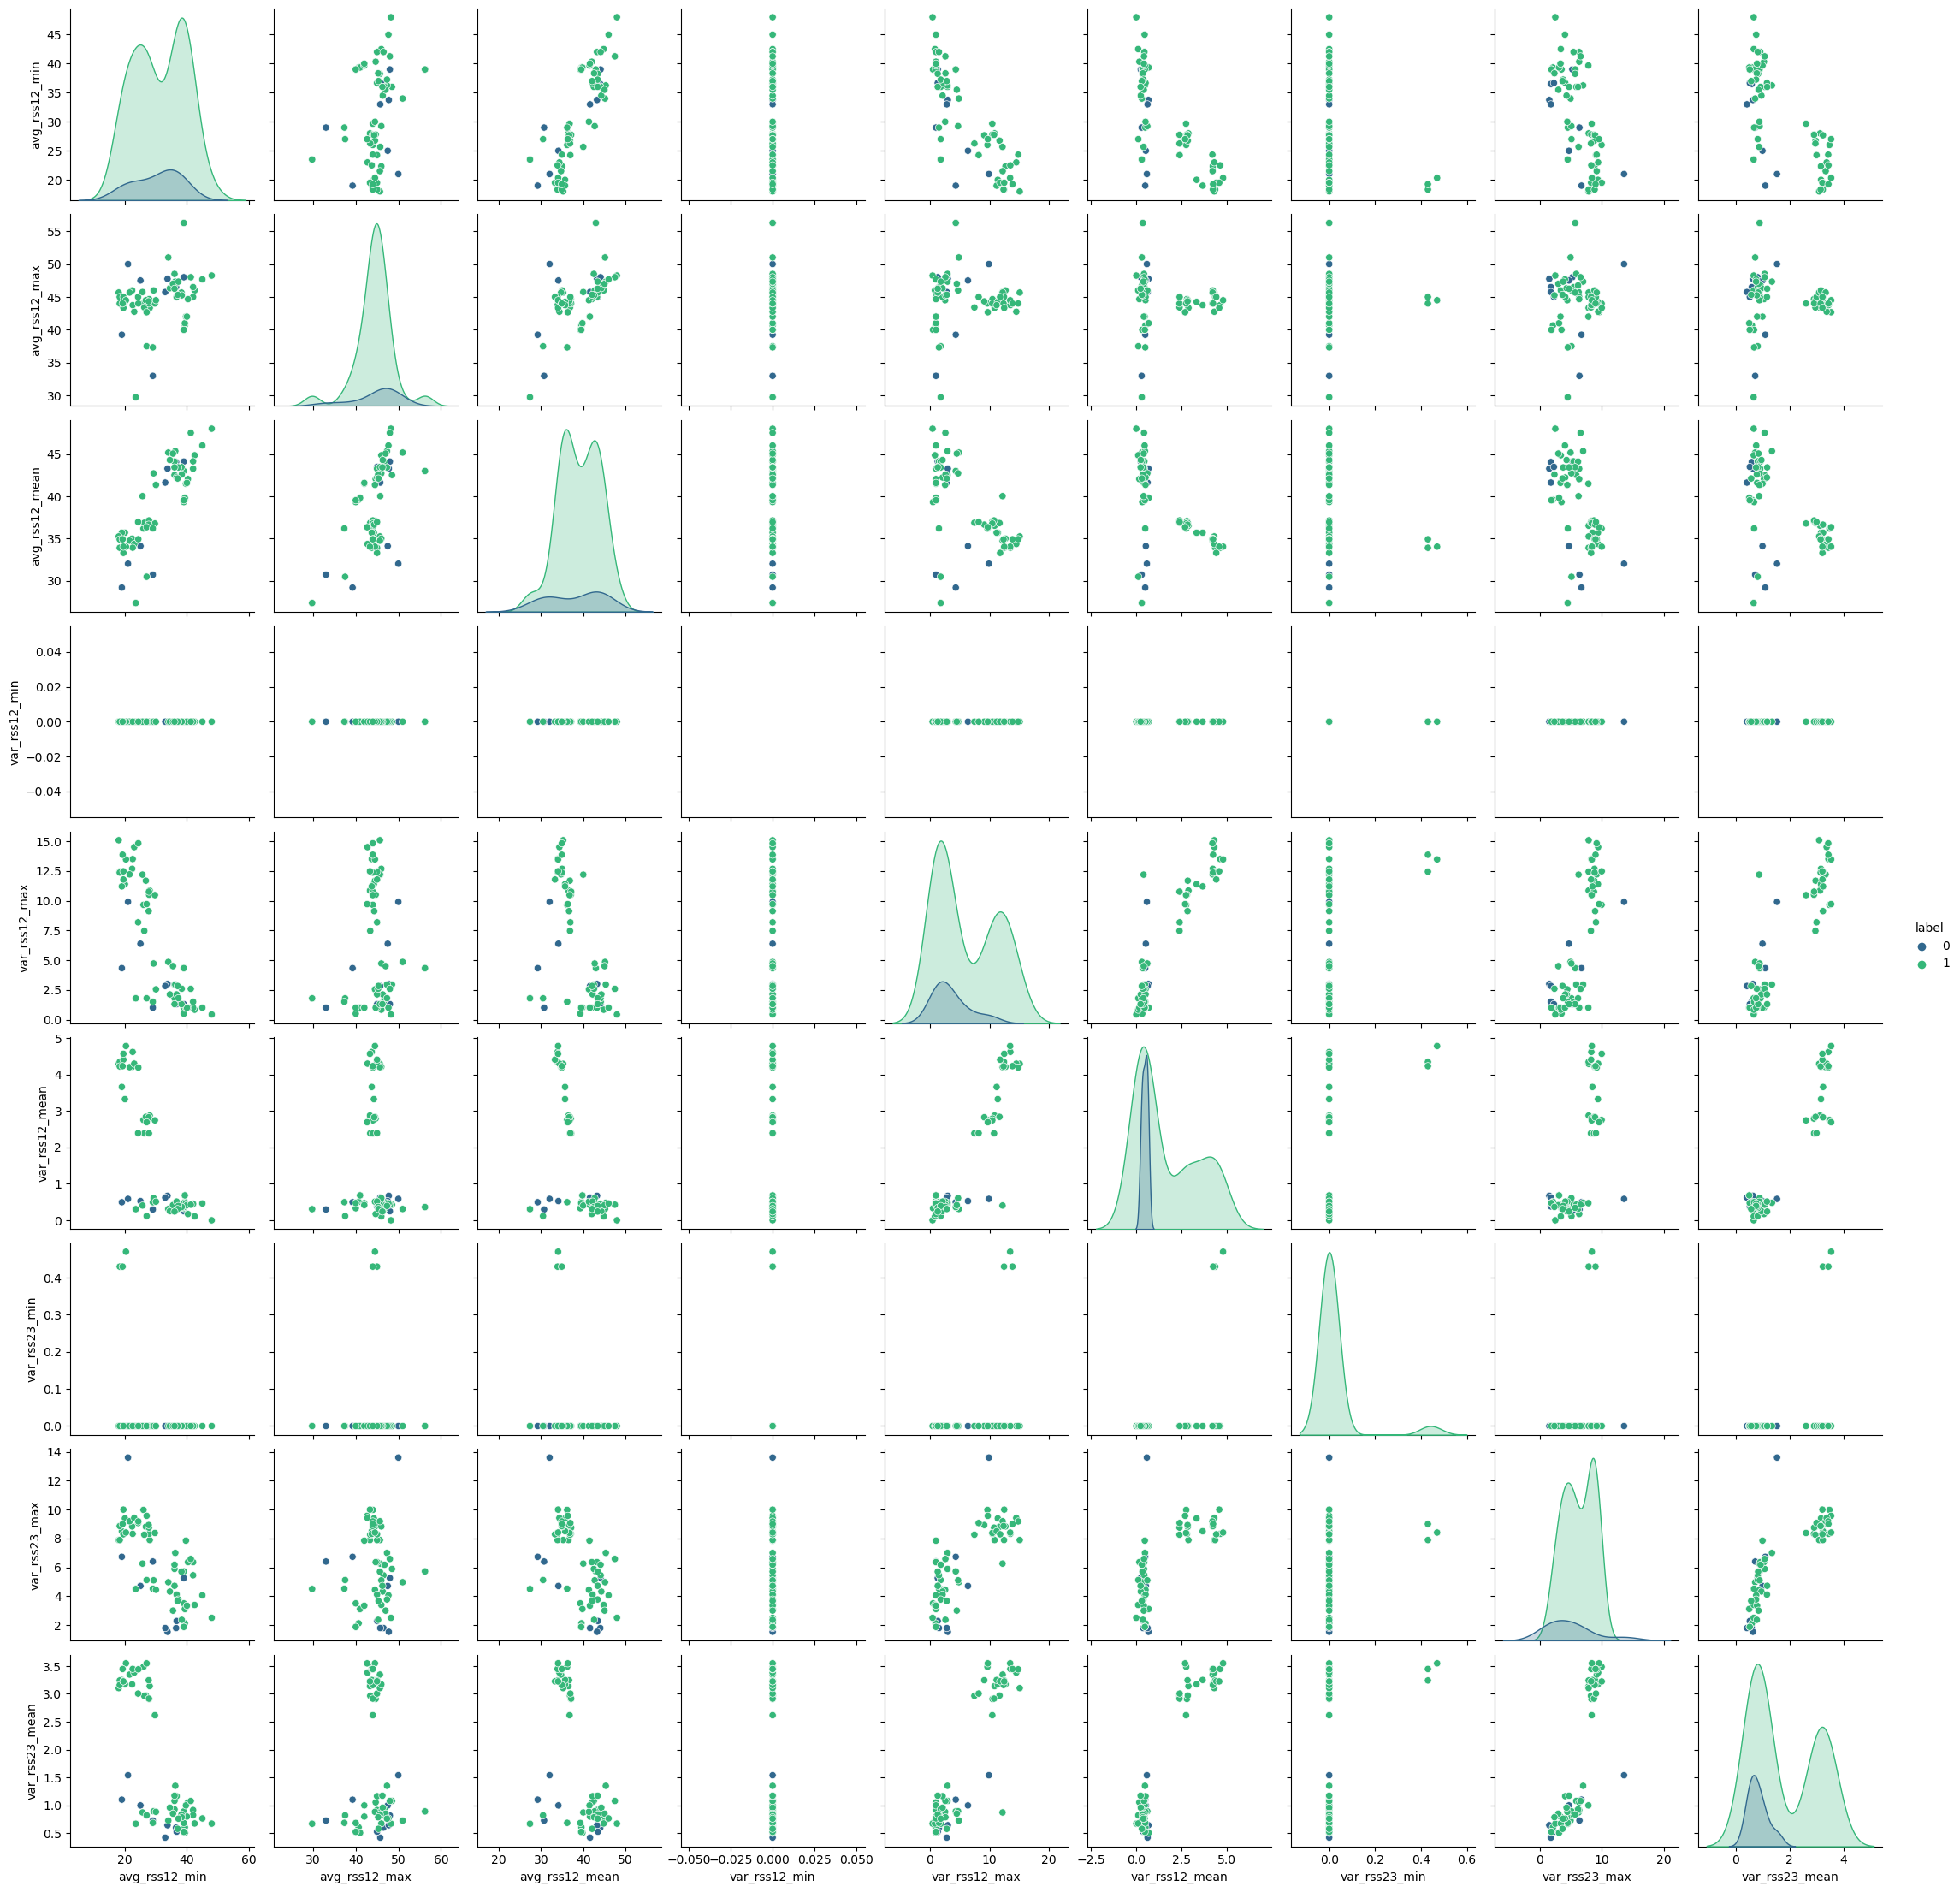

In [26]:
pairplot = sns.pairplot(part1_df, vars=columns_to_plot, hue='label', palette='viridis')
plt.show()

The reason why we are spliting the data to 2 parts is because our data is time series data. So we want to find out if the time affects the data in some point. And according to the plots above, we found out that some time series features are different depends on the time. For example, the var_rss12 mean is significant different.  So we need to consider the time as a factor to the classification.

#### iii. Time Series Segments

#### Breaking each time series

In [27]:
# break each time series
df_train_ii

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,category,label
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending,0
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending,0
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending,0
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending,0
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending,0
...,...,...,...,...,...,...,...,...,...
33114,118750,34.50,6.18,9.00,3.56,12.67,4.19,walking,1
33115,119000,25.75,6.02,13.75,2.05,16.00,1.58,walking,1
33116,119250,31.50,3.35,10.25,5.12,16.25,2.95,walking,1
33117,119500,33.75,2.77,14.00,3.24,13.75,0.43,walking,1


In [28]:
# Create a function to split the data from instance
def split_and_calculate_stats(df, num_splits, instance_length):
    stats_list = []
    instance_counter = 0
    part_length = instance_length // num_splits

    for start in range(0, len(df), instance_length):
        instance_counter += 1
        end = start + instance_length
        end = min(end, len(df))

        label = df.iloc[start]['label']

        stats = {
            'instance': instance_counter,
            'label': label,
        }

        for i in range(num_splits):
            part_start = start + i * part_length
            part_end = min(start + (i + 1) * part_length, end)

            part = df.iloc[part_start:part_end]

            for col_prefix in ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']:
                part_col_name = f"part{i + 1}"
                stats[f"{col_prefix}_min_{part_col_name}"] = part[col_prefix].min()
                stats[f"{col_prefix}_max_{part_col_name}"] = part[col_prefix].max()
                stats[f"{col_prefix}_mean_{part_col_name}"] = part[col_prefix].mean()

        stats_list.append(stats)

    stats_df = pd.DataFrame(stats_list)
    return stats_df

In [29]:
# Split data to 1, 2, ..., 20 parts
for num_splits in range(1, 21):
    globals()[f"df_split{num_splits}"] = split_and_calculate_stats(df_train_ii, num_splits=num_splits, instance_length=480)

In [30]:
df_split20

,instance,label,avg_rss12_min_part1,avg_rss12_max_part1,avg_rss12_mean_part1,var_rss12_min_part1,var_rss12_max_part1,var_rss12_mean_part1,avg_rss13_min_part1,avg_rss13_max_part1,...,avg_rss13_mean_part20,var_rss13_min_part20,var_rss13_max_part20,var_rss13_mean_part20,avg_rss23_min_part20,avg_rss23_max_part20,avg_rss23_mean_part20,var_rss23_min_part20,var_rss23_max_part20,var_rss23_mean_part20
0,1,0,40.00,45.00,43.513750,0.00,0.87,0.387500,14.25,24.50,...,19.944167,0.00,1.79,0.434167,35.25,36.33,36.006667,0.00,1.30,0.183333
1,2,0,36.00,47.50,44.097083,0.00,3.00,0.651250,21.00,30.00,...,21.149583,0.00,4.72,1.080000,23.75,31.75,28.774583,0.00,1.30,0.350000
2,3,0,36.00,44.50,41.563750,0.00,1.22,0.464583,11.75,28.00,...,17.100833,0.00,2.35,0.544167,26.00,30.50,27.541667,0.00,1.00,0.307500
3,4,0,41.00,46.75,44.756667,0.00,1.30,0.288750,11.50,24.00,...,17.003750,0.00,2.29,0.913333,8.00,23.67,19.430417,0.00,4.06,1.074583
4,5,0,41.50,44.25,42.951250,0.00,0.94,0.483333,12.00,21.00,...,11.946250,0.00,3.27,1.313333,21.50,24.67,23.228333,0.00,1.73,0.671250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,1,27.00,39.25,34.010417,0.47,9.63,4.121250,9.00,22.25,...,15.722500,0.82,6.72,3.021250,9.33,22.00,16.326250,0.47,6.00,3.350000
65,66,1,27.00,44.50,35.184167,1.58,13.47,6.247500,9.25,20.00,...,15.243333,0.47,7.18,3.175000,12.00,20.50,16.017083,0.50,8.38,3.554167
66,67,1,24.00,41.50,33.934167,0.00,8.81,3.967500,9.50,21.00,...,14.755833,1.12,8.22,3.707083,7.33,21.00,15.023750,1.25,7.72,3.929583
67,68,1,24.75,42.75,35.117917,1.30,10.74,4.468333,10.00,24.25,...,14.972917,1.25,7.00,2.891250,7.00,19.00,14.916667,0.82,6.87,3.960000


#### Using RFECV to find the best p for each l

In [31]:
best_p_values_all_splits = {}

for i in range(1, 21):
    df_split = globals()[f"df_split{i}"]
    
    X_train = df_split.drop(columns=['instance', 'label'])
    y_train = df_split['label']

    logit = LogisticRegression(max_iter=1000)
    rfecv = RFECV(estimator=logit, cv=5, n_jobs=-1) 
    rfecv.fit(X_train, y_train)
    
    best_p_index = np.argmax(rfecv.grid_scores_)
    best_p = best_p_index + 1
    best_accuracy = np.mean(rfecv.grid_scores_[best_p_index]) # Take mean of the array
    selected_features = X_train.columns[rfecv.support_]
    
    best_p_values_all_splits[f"df_split{i}"] = {
        'best_p': best_p, 
        'best_accuracy': best_accuracy,
        'selected_features': selected_features
    }

for split, values in best_p_values_all_splits.items():
    print(f"Dataset: {split}, Best p: {values['best_p']}, Best Accuracy: {values['best_accuracy']:.4f}")
    print("Selected Features:")
    for feature in values['selected_features']:
        print(f"\t{feature}")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(m

Dataset: df_split1, Best p: 1, Best Accuracy: 0.9418
Selected Features:
	avg_rss12_mean_part1
	avg_rss13_mean_part1
	avg_rss23_min_part1
	avg_rss23_max_part1
	avg_rss23_mean_part1
Dataset: df_split2, Best p: 1, Best Accuracy: 0.9275
Selected Features:
	avg_rss13_mean_part1
	avg_rss23_min_part1
	avg_rss23_max_part1
	avg_rss23_mean_part1
Dataset: df_split3, Best p: 2, Best Accuracy: 0.9286
Selected Features:
	avg_rss23_max_part1
Dataset: df_split4, Best p: 1, Best Accuracy: 0.9560
Selected Features:
	avg_rss23_max_part1
	avg_rss23_mean_part1
	avg_rss12_mean_part3
	var_rss23_max_part3
Dataset: df_split5, Best p: 1, Best Accuracy: 0.9418
Selected Features:
	avg_rss23_mean_part1
Dataset: df_split6, Best p: 1, Best Accuracy: 0.9286
Selected Features:
	avg_rss13_min_part1
	avg_rss23_mean_part1
	avg_rss23_max_part2
	avg_rss13_min_part6
	avg_rss23_mean_part6
	var_rss23_max_part6
Dataset: df_split7, Best p: 2, Best Accuracy: 0.9560
Selected Features:
	avg_rss23_min_part1
	avg_rss23_max_part1
	av

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Seem like the dataset with 13 split and with 1 parameter has the highest accuracy

It is very important for cross-validation to be done in the right manner, in the sense that the folds formed by splitting the time series data do not break the order in time. This would mean that each fold should represent a continuous segment of the time-series data in order to avoid information leakages and retain the temporal relationships concerning the target values. 

Very wrongly, time series data could be shuffled in a random way before being divided into folds for cross-validation. In fact, such a method would open the possibility of subtle data leakage by feeding future information into the training of the model, hence overestimating the performance, or very optimistic performance. It should also be noted that not adjusting for class imbalance, especially when using standard (non-stratified) cross-validation, can result in unreliable model evaluation, particularly where some of the folds do not have instances of the minority class.

#### iv. Confusion Matrix

In [32]:
df_split1

,instance,label,avg_rss12_min_part1,avg_rss12_max_part1,avg_rss12_mean_part1,var_rss12_min_part1,var_rss12_max_part1,var_rss12_mean_part1,avg_rss13_min_part1,avg_rss13_max_part1,avg_rss13_mean_part1,var_rss13_min_part1,var_rss13_max_part1,var_rss13_mean_part1,avg_rss23_min_part1,avg_rss23_max_part1,avg_rss23_mean_part1,var_rss23_min_part1,var_rss23_max_part1,var_rss23_mean_part1
0,1,0,35.00,47.40,43.954500,0.0,1.70,0.426250,6.50,29.75,22.122354,0.0,4.44,0.497313,29.00,38.50,35.588458,0.00,1.79,0.493292
1,2,0,33.00,47.75,42.179813,0.0,3.00,0.696042,8.50,30.00,22.183625,0.0,5.15,0.989917,20.00,38.67,33.493917,0.00,2.18,0.613521
2,3,0,33.00,45.75,41.678063,0.0,2.83,0.535979,3.00,28.25,19.006562,0.0,6.42,0.841875,23.67,37.50,29.857083,0.00,1.79,0.383292
3,4,0,37.00,48.00,43.454958,0.0,1.58,0.378083,5.75,27.00,15.793333,0.0,10.03,0.849354,8.00,33.50,23.034792,0.00,5.26,0.679646
4,5,0,36.25,48.00,43.969125,0.0,1.50,0.413125,1.50,26.33,15.868021,0.0,5.17,0.666354,11.33,30.75,22.103750,0.00,2.96,0.555313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,1,19.50,45.33,33.560667,0.0,14.67,4.570375,7.33,23.25,15.323062,0.0,9.00,3.230000,6.33,25.00,15.896313,0.00,8.32,3.259042
65,66,1,19.75,45.50,34.330562,0.0,13.47,4.461417,6.25,22.25,15.204562,0.0,9.00,3.275104,6.25,23.25,15.537958,0.00,9.67,3.438562
66,67,1,19.50,46.00,34.542063,0.0,12.47,4.373833,7.00,22.67,15.182083,0.0,8.34,3.026333,7.00,22.75,15.765792,0.00,10.00,3.337250
67,68,1,23.50,46.25,34.886250,0.0,14.82,4.391333,6.67,24.25,15.474833,0.0,9.90,3.211479,5.50,23.50,15.873896,0.00,9.51,3.424187


Accuracy: 0.9710144927536232
Confusion Matrix:
[[ 7  2]
 [ 0 60]]
AUC: 0.9925925925925926


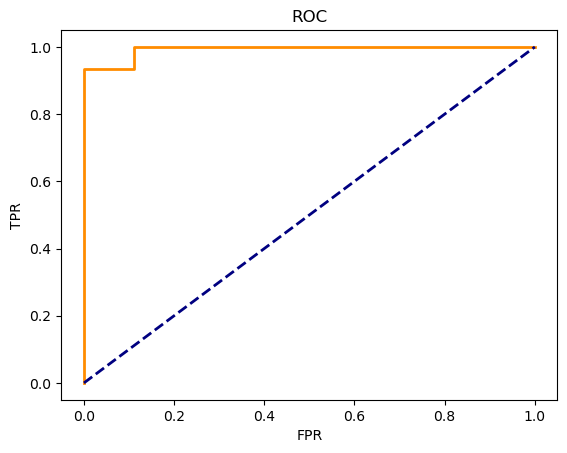

Dataset: df_split20, Best p: 1, Best Accuracy: 0.9418
Selected Features:
Index(['avg_rss12_mean_part1', 'avg_rss13_mean_part1', 'avg_rss23_min_part1',
       'avg_rss23_max_part1', 'avg_rss23_mean_part1'],
      dtype='object')
Logistic Regression Coefficients:
[[-1.06078747]]
avg_rss23_mean_part2: Coefficient = -1.0608, p-value = 0.0000


In [33]:
# Use the df_split13 p=1 model


X = df_split13.drop(columns=['instance','label']) 
y = df_split13['label']


logit = LogisticRegression(max_iter=1000)
rfecv = RFECV(estimator=logit, cv=5, scoring='accuracy')
rfecv.fit(X, y)

selected_features = X.columns[rfecv.support_]

logit.fit(X[selected_features], y)

y_pred = logit.predict(X[selected_features])


accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

y_score = logit.decision_function(X[selected_features])
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

values = best_p_values_all_splits['df_split1']
print(f"Dataset: {split}, Best p: {values['best_p']}, Best Accuracy: {values['best_accuracy']:.4f}")
print("Selected Features:")
print(values['selected_features'])
print("Logistic Regression Coefficients:")
print(logit.coef_)

# P-value
logit.fit(X[selected_features], y)
std_errors = np.sqrt(np.diag(np.linalg.inv(np.dot(X[selected_features].T, X[selected_features]))))

z_values = logit.coef_[0] / std_errors
p_values = norm.sf(np.abs(z_values)) * 2
for coef, p_val, feature in zip(logit.coef_[0], p_values, selected_features):
    print(f"{feature}: Coefficient = {coef:.4f}, p-value = {p_val:.4f}")

#### v. Test Classifier

In [34]:
# Label 'bending' as 0 and others as 1
df_test_bending = df_test.copy()
df_test_bending['label'] = df_test_bending['category'].apply(lambda x: 0 if x == 'bending' else 1)
df_test_bending

# 0 as bending, 1 as others
test_split13 = split_and_calculate_stats(df_test_bending, num_splits=13, instance_length=480)
test_split13

,instance,label,avg_rss12_min_part1,avg_rss12_max_part1,avg_rss12_mean_part1,var_rss12_min_part1,var_rss12_max_part1,var_rss12_mean_part1,avg_rss13_min_part1,avg_rss13_max_part1,...,avg_rss13_mean_part13,var_rss13_min_part13,var_rss13_max_part13,var_rss13_mean_part13,avg_rss23_min_part13,avg_rss23_max_part13,avg_rss23_mean_part13,var_rss23_min_part13,var_rss23_max_part13,var_rss23_mean_part13
0,1,1,30.75,43.25,36.488333,0.00,6.18,2.492222,8.50,23.33,...,16.171389,0.00,6.98,2.630278,14.50,23.50,19.950556,0.43,8.17,2.692778
1,2,1,33.33,41.75,37.185000,0.00,3.90,2.122778,8.75,21.00,...,16.006389,0.82,7.69,3.181944,15.00,23.50,20.363611,0.00,8.83,2.435278
2,3,1,31.33,44.00,37.676111,0.00,12.99,2.243333,7.00,24.00,...,16.164444,0.00,7.12,2.652500,7.50,20.67,15.436111,0.50,8.50,3.969167
3,4,1,28.50,29.00,28.951389,0.00,0.50,0.073611,3.00,9.00,...,8.828889,0.00,3.24,1.134444,7.75,15.75,10.713056,0.00,3.30,0.943889
4,5,1,29.00,30.00,29.126944,0.00,0.50,0.139722,1.00,7.50,...,6.194722,0.00,0.83,0.331667,1.00,4.00,1.837778,0.00,1.25,0.464722
5,6,1,48.00,48.00,48.000000,0.00,0.00,0.000000,5.00,6.33,...,4.599722,0.00,1.58,0.527778,9.00,11.50,10.409722,0.00,1.12,0.724167
6,7,1,41.75,42.25,41.993056,0.00,0.43,0.035833,14.67,19.33,...,15.696667,0.00,3.30,0.890833,9.50,28.00,18.641667,0.00,5.79,1.183889
7,8,1,37.00,50.75,47.659722,0.00,4.87,0.453611,16.00,24.00,...,17.754444,0.00,4.58,1.094722,2.00,20.25,13.267778,0.00,7.22,2.293056
8,9,1,45.00,46.67,45.465278,0.00,0.83,0.345833,4.33,21.00,...,10.849722,0.00,3.90,1.099167,17.67,22.00,20.285000,0.00,1.30,0.547500
9,10,1,46.00,47.00,46.483611,0.00,0.83,0.490833,9.75,18.75,...,14.802778,0.00,4.76,0.857222,7.00,18.25,13.976667,0.00,3.27,0.859167


Accuracy on Test Set: 0.9473684210526315
Accuracy(Cross-Validation): 0.9710144927536232
Confusion Matrix on Test Set:
[[ 3  1]
 [ 0 15]]
AUC on Test Set: 0.8333333333333334


Text(0.5, 1.0, 'ROC for test')

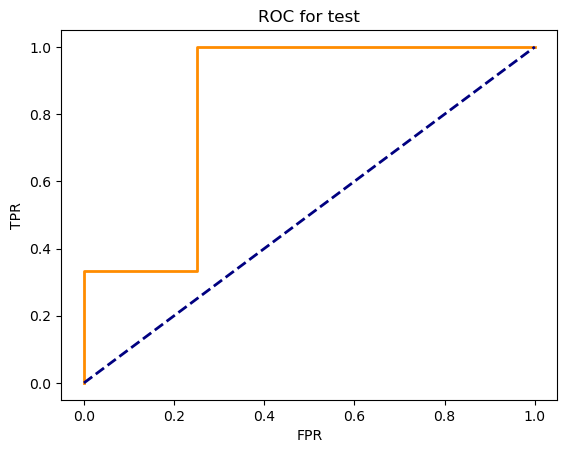

In [35]:
X_test = test_split13.drop(columns=['instance','label']) 
y_test = test_split13['label']
X_test_selected = X_test[selected_features]
y_pred_test = logit.predict(X_test_selected)


accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on Test Set:", accuracy_test)
print("Accuracy(Cross-Validation):", accuracy)

y_score_test = logit.decision_function(X_test_selected)

# confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix on Test Set:")
print(conf_matrix_test)

# ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)

# AUC
roc_auc_test = auc(fpr_test, tpr_test)
print("AUC on Test Set:", roc_auc_test)

# Plot ROC curve
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for test')

> The cross-validation accuracy is 0.9710 and the test set accuracy is 0.9474 which is still close to the training accuracy. 

#### vi. Separation

In the information given, therefore, the logistic regression model depicts high accuracy based on both cross-validation and the test set; the AUC value of the test set ROC curve is high. These results are clear evidence of good classes separation, since the model discriminates well between the two classes in relation to the selected features. 

#### vii. Imbalance

Based on the confusion matrices in the previous section, the class appear to be imbalanced. In the training confusion matrix, there is a class that has 9 instances and another class that has 60 instances. In the test confusion matrix there is 3 instances in one class and 15 in others

Training Confusion Matrix:
[[60  0]
 [ 0 60]]
Test Confusion Matrix:
[[ 4  0]
 [ 0 15]]


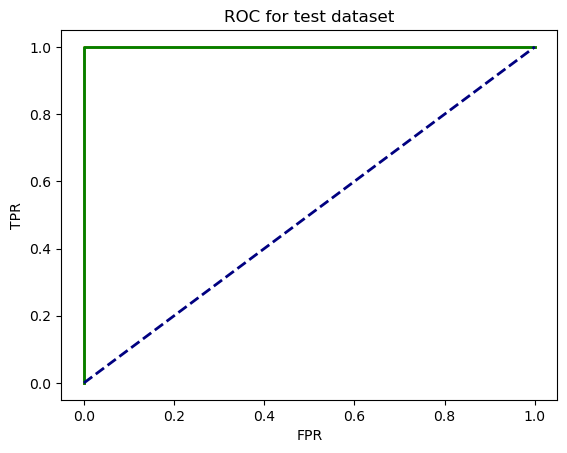

In [36]:
X_train = df_split13.drop(['instance', 'label'], axis=1)
y_train = df_split13['label']
X_test = test_split13.drop(['instance', 'label'], axis=1)
y_test = test_split13['label']


train_data = pd.concat([X_train, y_train], axis=1)

majority = train_data[train_data.label == 1]
minority = train_data[train_data.label == 0]

# Upsample
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=123)

balanced_df = pd.concat([majority, minority_upsampled])
X_train_balanced = balanced_df.drop('label', axis=1)
y_train_balanced = balanced_df['label']

model = LogisticRegression(max_iter=1000)
model.fit(X_train_balanced, y_train_balanced)
y_train_pred = model.predict(X_train_balanced)


train_conf_matrix = confusion_matrix(y_train_balanced, y_train_pred)
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC
y_train_pred_proba = model.predict_proba(X_train_balanced)[:, 1]
train_fpr, train_tpr, _ = roc_curve(y_train_balanced, y_train_pred_proba)
train_roc_auc = auc(train_fpr, train_tpr)

# Confusion Matrix
print("Training Confusion Matrix:")
print(train_conf_matrix)
print("Test Confusion Matrix:")
print(conf_matrix)

# plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot(train_fpr, train_tpr, color='green', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for test dataset')
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [37]:
# pointers
best_overall_performance = -np.inf
best_l = None
best_C = None
best_accuracy = None
best_p = None
results = {}

for l in range(1, 21):
    df_split = globals()[f"df_split{l}"]
    
    X_train = df_split.drop(columns=['instance', 'label'])
    y_train = df_split['label']
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # penalty = 11 = L1
    logit_cv = LogisticRegressionCV(penalty='l1', cv=5, max_iter=5000, solver='saga', n_jobs=-1)
    logit_cv.fit(X_train_scaled, y_train)

    mean_score = np.max(logit_cv.scores_[1].mean(axis=0))
    
    # number of features
    num_effective_features = np.sum(logit_cv.coef_ != 0)
    current_C = 1 / logit_cv.C_[0] # lambda
    
    # Update the best parameters
    if mean_score > best_overall_performance:
        best_overall_performance = mean_score
        best_l = l
        best_C = current_C
        best_accuracy = mean_score
        best_p = num_effective_features
    
    results[l] = {
        'best_C': current_C, 
        'accuracy': mean_score,
        'num_effective_features': num_effective_features
    }

print(f"Best l: {best_l}, Best C: {best_C}, Best Accuracy: {best_accuracy:.4f}, Best p: {best_p}")

for l, info in results.items():
    print(f"l = {l}: Best C = {info['best_C']:.8f}, Accuracy = {info['accuracy']:.8f}, Effective Features: {info['num_effective_features']}")

Best l: 1, Best C: 2.782559402207126, Best Accuracy: 0.9714, Best p: 3
l = 1: Best C = 2.78255940, Accuracy = 0.97142857, Effective Features: 3
l = 2: Best C = 2.78255940, Accuracy = 0.97142857, Effective Features: 4
l = 3: Best C = 2.78255940, Accuracy = 0.97142857, Effective Features: 4
l = 4: Best C = 2.78255940, Accuracy = 0.95714286, Effective Features: 5
l = 5: Best C = 0.35938137, Accuracy = 0.94175824, Effective Features: 14
l = 6: Best C = 0.04641589, Accuracy = 0.92857143, Effective Features: 39
l = 7: Best C = 0.04641589, Accuracy = 0.95604396, Effective Features: 40
l = 8: Best C = 0.35938137, Accuracy = 0.94175824, Effective Features: 17
l = 9: Best C = 0.00599484, Accuracy = 0.92857143, Effective Features: 137
l = 10: Best C = 0.35938137, Accuracy = 0.92747253, Effective Features: 17
l = 11: Best C = 0.35938137, Accuracy = 0.92747253, Effective Features: 18
l = 12: Best C = 0.35938137, Accuracy = 0.92857143, Effective Features: 14
l = 13: Best C = 0.35938137, Accuracy = 0

#### ii. Comparison

Comparing the L1-regularized logistic regression and the standard logistic regression based on the effective features, the standard logistic regression(with a best accuracy of 0.9857 and 5 effective features) outperforms the L1-regularized version(which has accuracy of 0.9714 with 3 effective features) in terms of accuracy. L1-regularized logistic regression may need a little more handling, particularly with respect to the regularization parameter "C," which may need cross-validation and hence a little more involved compared to a logistic regression that does not require such parameter tuning. 

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [38]:
def split_and_calculate_stats_multi_class(df, num_splits, instance_length):
    stats_list = []
    instance_counter = 0
    part_length = instance_length // num_splits

    for start in range(0, len(df), instance_length):
        instance_counter += 1
        end = start + instance_length
        end = min(end, len(df))

        category = df.iloc[start]['category'] 

        stats = {
            'instance': instance_counter,
            'category': category,  
        }

        for i in range(num_splits):
            part_start = start + i * part_length
            part_end = min(start + (i + 1) * part_length, end)

            part = df.iloc[part_start:part_end]

            for col_prefix in ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']:
                part_col_name = f"part{i + 1}"
                stats[f"{col_prefix}_min_{part_col_name}"] = part[col_prefix].min()
                stats[f"{col_prefix}_max_{part_col_name}"] = part[col_prefix].max()
                stats[f"{col_prefix}_mean_{part_col_name}"] = part[col_prefix].mean()

        stats_list.append(stats)

    stats_df = pd.DataFrame(stats_list)
    return stats_df

In [39]:
for num_splits in range(1, 21):
    globals()[f"mult_split{num_splits}"] = split_and_calculate_stats_multi_class(df_train_ii, num_splits=num_splits, instance_length=480)

In [40]:
mult_split20['category'].unique()

array(['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking'],
      dtype=object)

In [41]:
mult_split1

,instance,category,avg_rss12_min_part1,avg_rss12_max_part1,avg_rss12_mean_part1,var_rss12_min_part1,var_rss12_max_part1,var_rss12_mean_part1,avg_rss13_min_part1,avg_rss13_max_part1,avg_rss13_mean_part1,var_rss13_min_part1,var_rss13_max_part1,var_rss13_mean_part1,avg_rss23_min_part1,avg_rss23_max_part1,avg_rss23_mean_part1,var_rss23_min_part1,var_rss23_max_part1,var_rss23_mean_part1
0,1,bending,35.00,47.40,43.954500,0.0,1.70,0.426250,6.50,29.75,22.122354,0.0,4.44,0.497313,29.00,38.50,35.588458,0.00,1.79,0.493292
1,2,bending,33.00,47.75,42.179813,0.0,3.00,0.696042,8.50,30.00,22.183625,0.0,5.15,0.989917,20.00,38.67,33.493917,0.00,2.18,0.613521
2,3,bending,33.00,45.75,41.678063,0.0,2.83,0.535979,3.00,28.25,19.006562,0.0,6.42,0.841875,23.67,37.50,29.857083,0.00,1.79,0.383292
3,4,bending,37.00,48.00,43.454958,0.0,1.58,0.378083,5.75,27.00,15.793333,0.0,10.03,0.849354,8.00,33.50,23.034792,0.00,5.26,0.679646
4,5,bending,36.25,48.00,43.969125,0.0,1.50,0.413125,1.50,26.33,15.868021,0.0,5.17,0.666354,11.33,30.75,22.103750,0.00,2.96,0.555313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,walking,19.50,45.33,33.560667,0.0,14.67,4.570375,7.33,23.25,15.323062,0.0,9.00,3.230000,6.33,25.00,15.896313,0.00,8.32,3.259042
65,66,walking,19.75,45.50,34.330562,0.0,13.47,4.461417,6.25,22.25,15.204562,0.0,9.00,3.275104,6.25,23.25,15.537958,0.00,9.67,3.438562
66,67,walking,19.50,46.00,34.542063,0.0,12.47,4.373833,7.00,22.67,15.182083,0.0,8.34,3.026333,7.00,22.75,15.765792,0.00,10.00,3.337250
67,68,walking,23.50,46.25,34.886250,0.0,14.82,4.391333,6.67,24.25,15.474833,0.0,9.90,3.211479,5.50,23.50,15.873896,0.00,9.51,3.424187


In [42]:
best_overall_accuracy = -np.inf
best_l = None
best_C = None
best_non_zero_coefs_per_class = [] 
results = {}

for l in range(1, 21):
    df_split = globals()[f"mult_split{l}"]
    
    X_train = df_split.drop(columns=['instance', 'category'])
    y_train = df_split['category']
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    logit_cv = LogisticRegressionCV(penalty='l1', multi_class='multinomial', cv=5, max_iter=10000, solver='saga', n_jobs=-1)
    logit_cv.fit(X_train_scaled, y_train)

    mean_accuracy = np.mean([np.max(logit_cv.scores_[class_label].mean(axis=0)) for class_label in logit_cv.scores_])
    
    non_zero_coefs_per_class = np.sum(logit_cv.coef_ != 0, axis=1)
    
    current_C = 1 / logit_cv.C_[0]  
    
    if mean_accuracy > best_overall_accuracy or (mean_accuracy == best_overall_accuracy and current_C < best_C):
        best_overall_accuracy = mean_accuracy
        best_l = l
        best_C = current_C
        best_non_zero_coefs_per_class = non_zero_coefs_per_class.tolist() 
    
    results[l] = {
        'best_C': current_C,  
        'accuracy': mean_accuracy,
        'non_zero_coefs_per_class': non_zero_coefs_per_class.tolist()
    }

print('There are 6 classes total')
print('Non-Zero Coefficients per Class for Best Model: The number of features with non-zero coefficients used by the model to classify instances into the first to sixth class. ')
print(f"Best l: {best_l}, Best C: {best_C:.8f}, Best Accuracy: {best_overall_accuracy:.4f}, Non-Zero Coefficients per Class for Best Model: {best_non_zero_coefs_per_class}")

for l, info in results.items():
    print(f"l = {l}: Best C = {info['best_C']:.8f}, Accuracy = {info['accuracy']:.8f}, Features used per class: {info['non_zero_coefs_per_class']}")

There are 6 classes total
Non-Zero Coefficients per Class for Best Model: The number of features with non-zero coefficients used by the model to classify instances into the first to sixth class. 
Best l: 1, Best C: 0.35938137, Best Accuracy: 0.8846, Non-Zero Coefficients per Class for Best Model: [5, 3, 4, 4, 5, 1]
l = 1: Best C = 0.35938137, Accuracy = 0.88461538, Features used per class: [5, 3, 4, 4, 5, 1]
l = 2: Best C = 2.78255940, Accuracy = 0.88461538, Features used per class: [5, 2, 4, 3, 4, 5]
l = 3: Best C = 0.00599484, Accuracy = 0.79780220, Features used per class: [35, 42, 32, 41, 39, 37]
l = 4: Best C = 0.00599484, Accuracy = 0.78351648, Features used per class: [49, 51, 50, 57, 51, 46]
l = 5: Best C = 0.35938137, Accuracy = 0.74065934, Features used per class: [8, 12, 9, 12, 13, 14]
l = 6: Best C = 0.04641589, Accuracy = 0.75384615, Features used per class: [22, 28, 27, 47, 39, 22]
l = 7: Best C = 0.00599484, Accuracy = 0.76703297, Features used per class: [80, 91, 92, 11

In [43]:
test_mult_split1 = split_and_calculate_stats_multi_class(df_test_bending, num_splits=1, instance_length=480)
test_mult_split1

,instance,category,avg_rss12_min_part1,avg_rss12_max_part1,avg_rss12_mean_part1,var_rss12_min_part1,var_rss12_max_part1,var_rss12_mean_part1,avg_rss13_min_part1,avg_rss13_max_part1,avg_rss13_mean_part1,var_rss13_min_part1,var_rss13_max_part1,var_rss13_mean_part1,avg_rss23_min_part1,avg_rss23_max_part1,avg_rss23_mean_part1,var_rss23_min_part1,var_rss23_max_part1,var_rss23_mean_part1
0,1,cycling,24.25,45.00,37.177042,0.0,8.58,2.374208,5.50,26.75,16.531083,0.0,8.05,2.910604,7.00,25.50,19.607250,0.0,9.34,2.921729
1,2,cycling,28.75,44.75,37.561188,0.0,9.91,2.080688,6.50,24.67,16.567042,0.0,8.32,3.033875,10.50,24.33,19.518896,0.0,9.62,2.765896
2,3,cycling,22.00,44.67,37.058708,0.0,14.17,2.438146,6.33,24.00,16.388312,0.0,9.74,2.980688,7.50,24.25,18.125958,0.0,8.55,2.983750
3,4,lying,23.50,30.00,27.716375,0.0,1.79,0.363688,0.00,13.25,6.078563,0.0,5.02,0.871021,0.00,21.00,8.337438,0.0,4.50,0.734271
4,5,lying,24.75,48.33,44.182937,0.0,3.11,0.101875,1.00,16.50,6.679958,0.0,5.91,0.584104,0.00,12.75,4.376292,0.0,3.91,0.692771
5,6,lying,48.00,48.25,48.004167,0.0,0.43,0.007167,0.00,13.00,4.900563,0.0,2.86,0.397313,0.00,12.00,7.624896,0.0,2.50,0.641229
6,7,sitting,33.25,48.00,42.363563,0.0,4.44,0.492563,3.00,22.50,17.119292,0.0,5.36,0.641854,1.00,28.00,13.381771,0.0,6.02,1.034021
7,8,sitting,37.00,50.75,45.917667,0.0,4.87,0.324542,0.00,24.00,16.871542,0.0,8.50,0.696375,2.00,24.00,18.442792,0.0,7.22,0.904604
8,9,sitting,44.50,46.75,45.239667,0.0,1.00,0.172958,2.00,23.75,12.813313,0.0,6.36,1.108688,4.75,26.75,19.330667,0.0,8.20,0.837250
9,10,standing,33.33,48.00,44.334729,0.0,3.90,0.432958,0.00,18.75,11.646146,0.0,5.79,0.843063,0.00,23.00,13.443708,0.0,5.02,0.933000


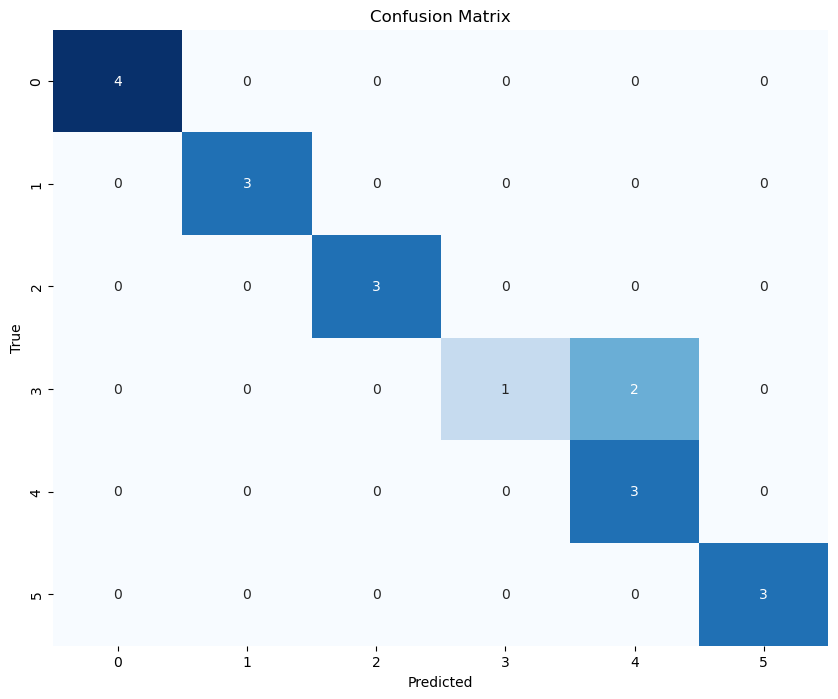

Best_C is:  0.3593813663804626

Confusion Matrix:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 1 2 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]

Accuracy: 0.8947368421052632

Classification Report:
              precision    recall  f1-score   support

     bending       1.00      1.00      1.00         4
     cycling       1.00      1.00      1.00         3
       lying       1.00      1.00      1.00         3
     sitting       1.00      0.33      0.50         3
    standing       0.60      1.00      0.75         3
     walking       1.00      1.00      1.00         3

    accuracy                           0.89        19
   macro avg       0.93      0.89      0.88        19
weighted avg       0.94      0.89      0.88        19



In [44]:
X_train = mult_split1.drop(['instance', 'category'], axis=1)
y_train = mult_split1['category']
X_test = test_mult_split1.drop(['instance', 'category'], axis=1)
y_test = test_mult_split1['category']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(penalty='l1', C=best_C, multi_class='multinomial', solver='saga', max_iter=10000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Best_C is: ',best_C)
print('')
# confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print("")
# Accuracy
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

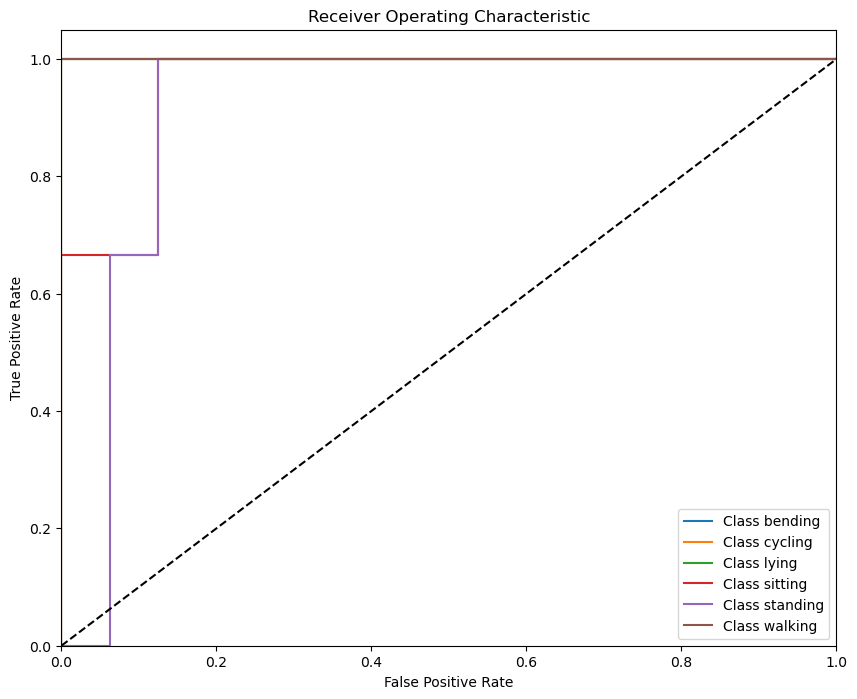

In [45]:
y_pred_prob = model.predict_proba(X_test_scaled)


label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### ii. Naive Bayes

In [46]:
best_overall_accuracy_gaussian = -np.inf
best_l_gaussian = None
results_gaussian = {}

for l in range(1, 21):
    df_split = globals()[f"mult_split{l}"]
    
    X_train = df_split.drop(columns=['instance', 'category'])
    y_train = df_split['category']
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    

    gaussian_nb = GaussianNB()
    gaussian_nb.fit(X_train_scaled, y_train)
    gaussian_nb_accuracy = gaussian_nb.score(X_train_scaled, y_train)

    if gaussian_nb_accuracy > best_overall_accuracy_gaussian:
        best_overall_accuracy_gaussian = gaussian_nb_accuracy
        best_l_gaussian = l
    
    results_gaussian[l] = {
        'accuracy': gaussian_nb_accuracy
    }

print('Results for Gaussian Naive Bayes:')
for l, info in results_gaussian.items():
    print(f"l = {l}: Accuracy = {info['accuracy']:.8f}")

print(f"Best l for Gaussian Naive Bayes: {best_l_gaussian}, Best Accuracy: {best_overall_accuracy_gaussian:.4f}")

Results for Gaussian Naive Bayes:
l = 1: Accuracy = 0.95652174
l = 2: Accuracy = 0.98550725
l = 3: Accuracy = 0.95652174
l = 4: Accuracy = 0.95652174
l = 5: Accuracy = 0.91304348
l = 6: Accuracy = 0.92753623
l = 7: Accuracy = 0.89855072
l = 8: Accuracy = 0.89855072
l = 9: Accuracy = 0.95652174
l = 10: Accuracy = 0.95652174
l = 11: Accuracy = 0.94202899
l = 12: Accuracy = 0.94202899
l = 13: Accuracy = 0.97101449
l = 14: Accuracy = 0.98550725
l = 15: Accuracy = 0.97101449
l = 16: Accuracy = 0.97101449
l = 17: Accuracy = 0.98550725
l = 18: Accuracy = 0.97101449
l = 19: Accuracy = 1.00000000
l = 20: Accuracy = 0.98550725
Best l for Gaussian Naive Bayes: 19, Best Accuracy: 1.0000


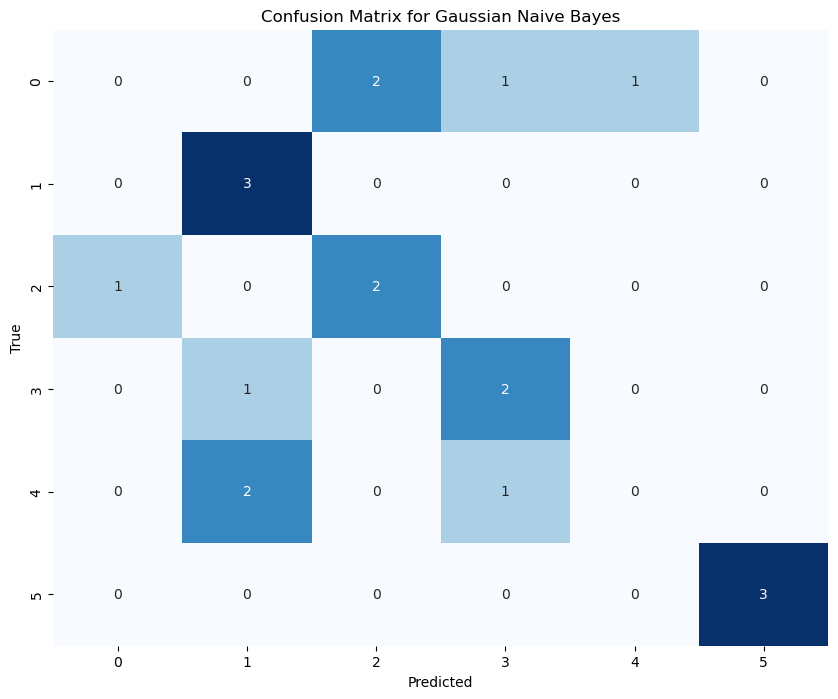

Accuracy: 0.5263157894736842

Confusion Matrix:
[[0 0 2 1 1 0]
 [0 3 0 0 0 0]
 [1 0 2 0 0 0]
 [0 1 0 2 0 0]
 [0 2 0 1 0 0]
 [0 0 0 0 0 3]]

Classification Report:
              precision    recall  f1-score   support

     bending       0.00      0.00      0.00         4
     cycling       0.50      1.00      0.67         3
       lying       0.50      0.67      0.57         3
     sitting       0.50      0.67      0.57         3
    standing       0.00      0.00      0.00         3
     walking       1.00      1.00      1.00         3

    accuracy                           0.53        19
   macro avg       0.42      0.56      0.47        19
weighted avg       0.39      0.53      0.44        19



In [47]:
test_mult_split19 = split_and_calculate_stats_multi_class(df_test_bending, num_splits=19, instance_length=480)
X_train = mult_split19.drop(['instance', 'category'], axis=1)
y_train = mult_split19['category']
X_test = test_mult_split19.drop(['instance', 'category'], axis=1)
y_test = test_mult_split19['category']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train_scaled, y_train)

y_pred_gaussian_nb = gaussian_nb.predict(X_test_scaled)

accuracy_gaussian_nb = accuracy_score(y_test, y_pred_gaussian_nb)

conf_matrix_gaussian_nb = confusion_matrix(y_test, y_pred_gaussian_nb)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_gaussian_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gaussian Naive Bayes')
plt.show()

print("Accuracy:", accuracy_gaussian_nb)
print("\nConfusion Matrix:")
print(conf_matrix_gaussian_nb)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gaussian_nb))

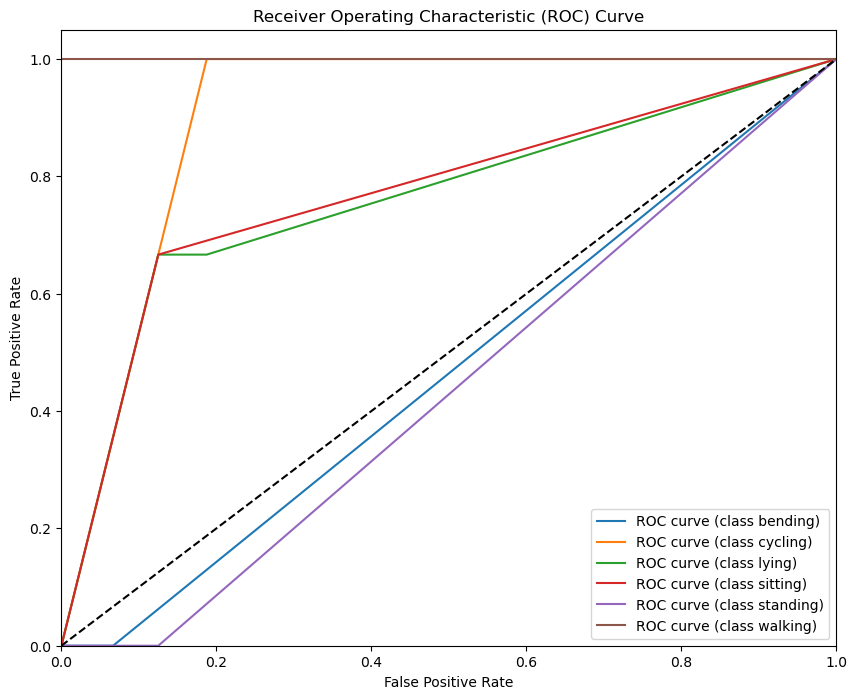

In [48]:
y_probs_gaussian_nb = gaussian_nb.predict_proba(X_test_scaled)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(gaussian_nb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == gaussian_nb.classes_[i], y_probs_gaussian_nb[:, i])
    roc_auc[i] = roc_auc_score(y_test == gaussian_nb.classes_[i], y_probs_gaussian_nb[:, i])

plt.figure(figsize=(10, 8))
for i in range(len(gaussian_nb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {gaussian_nb.classes_[i]})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [49]:
best_overall_accuracy_multinomial = -np.inf
best_l_multinomial = None
results_multinomial = {}

for l in range(1, 21):
    df_split = globals()[f"mult_split{l}"]
    
    X_train = df_split.drop(columns=['instance', 'category'])
    y_train = df_split['category']
    
    multinomial_nb = MultinomialNB()
    multinomial_nb.fit(X_train, y_train)
    multinomial_nb_accuracy = multinomial_nb.score(X_train, y_train)

    if multinomial_nb_accuracy > best_overall_accuracy_multinomial:
        best_overall_accuracy_multinomial = multinomial_nb_accuracy
        best_l_multinomial = l
    
    results_multinomial[l] = {
        'accuracy': multinomial_nb_accuracy
    }

print('Results for Multinomial Naive Bayes with Priors:')
for l, info in results_multinomial.items():
    print(f"l = {l}: Accuracy = {info['accuracy']:.8f}")

print(f"Best l for Multinomial Naive Bayes: {best_l_multinomial}, Best Accuracy: {best_overall_accuracy_multinomial:.4f}")

Results for Multinomial Naive Bayes with Priors:
l = 1: Accuracy = 0.82608696
l = 2: Accuracy = 0.85507246
l = 3: Accuracy = 0.88405797
l = 4: Accuracy = 0.88405797
l = 5: Accuracy = 0.91304348
l = 6: Accuracy = 0.91304348
l = 7: Accuracy = 0.91304348
l = 8: Accuracy = 0.91304348
l = 9: Accuracy = 0.91304348
l = 10: Accuracy = 0.89855072
l = 11: Accuracy = 0.92753623
l = 12: Accuracy = 0.94202899
l = 13: Accuracy = 0.92753623
l = 14: Accuracy = 0.92753623
l = 15: Accuracy = 0.95652174
l = 16: Accuracy = 0.92753623
l = 17: Accuracy = 0.95652174
l = 18: Accuracy = 0.95652174
l = 19: Accuracy = 0.95652174
l = 20: Accuracy = 0.95652174
Best l for Multinomial Naive Bayes: 15, Best Accuracy: 0.9565


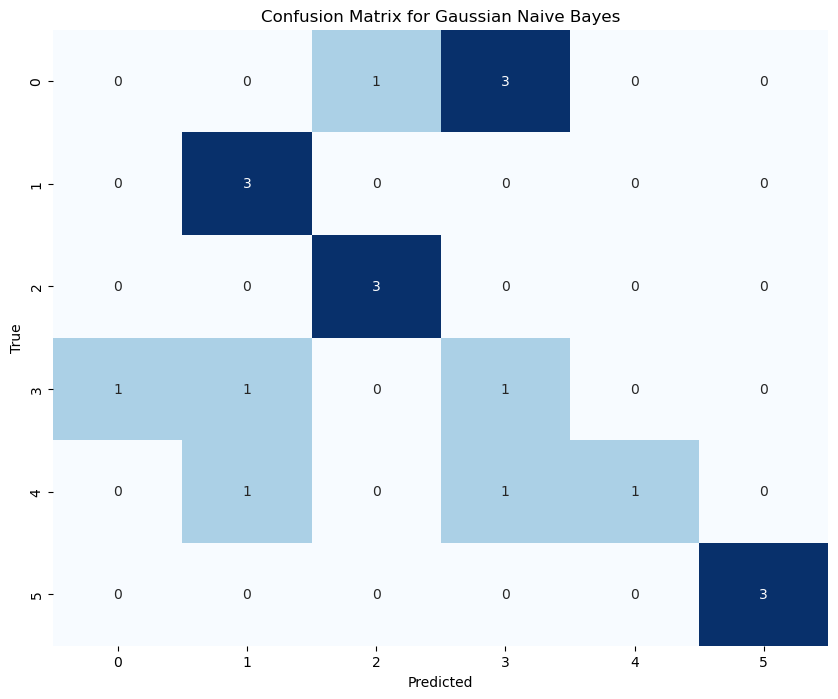

Accuracy: 0.5789473684210527

Confusion Matrix:
[[0 0 1 3 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [1 1 0 1 0 0]
 [0 1 0 1 1 0]
 [0 0 0 0 0 3]]

Classification Report:
              precision    recall  f1-score   support

     bending       0.00      0.00      0.00         4
     cycling       0.60      1.00      0.75         3
       lying       0.75      1.00      0.86         3
     sitting       0.20      0.33      0.25         3
    standing       1.00      0.33      0.50         3
     walking       1.00      1.00      1.00         3

    accuracy                           0.58        19
   macro avg       0.59      0.61      0.56        19
weighted avg       0.56      0.58      0.53        19



In [50]:
test_mult_split15 = split_and_calculate_stats_multi_class(df_test_bending, num_splits=15, instance_length=480)
X_train = mult_split15.drop(['instance', 'category'], axis=1)
y_train = mult_split15['category']
X_test = test_mult_split15.drop(['instance', 'category'], axis=1)
y_test = test_mult_split15['category']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train_scaled, y_train)


y_pred_gaussian_nb = gaussian_nb.predict(X_test_scaled)

accuracy_gaussian_nb = accuracy_score(y_test, y_pred_gaussian_nb)

conf_matrix_gaussian_nb = confusion_matrix(y_test, y_pred_gaussian_nb)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_gaussian_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gaussian Naive Bayes')
plt.show()

print("Accuracy:", accuracy_gaussian_nb)
print("\nConfusion Matrix:")
print(conf_matrix_gaussian_nb)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gaussian_nb))

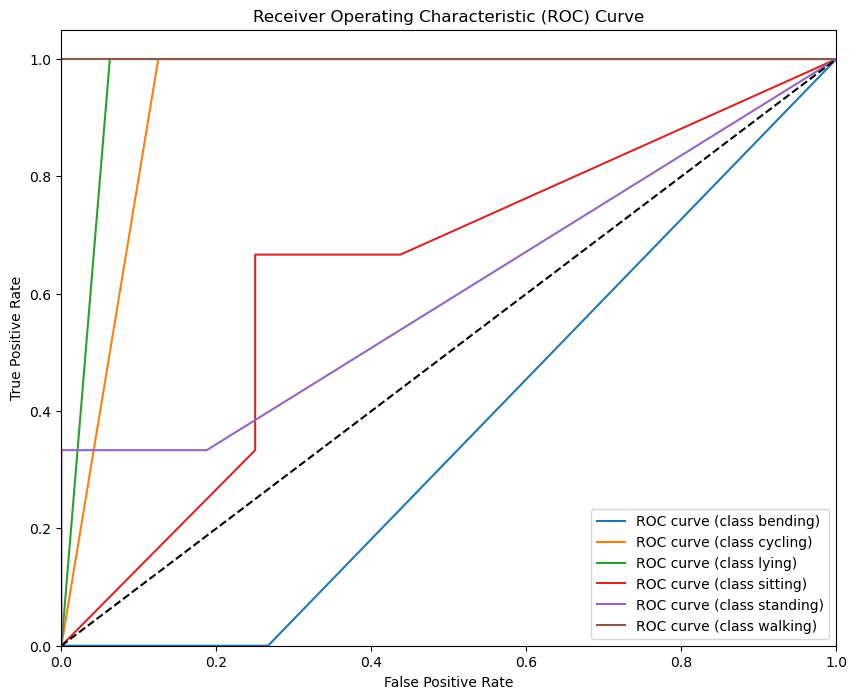

In [51]:
y_probs_gaussian_nb = gaussian_nb.predict_proba(X_test_scaled)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(gaussian_nb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == gaussian_nb.classes_[i], y_probs_gaussian_nb[:, i])
    roc_auc[i] = roc_auc_score(y_test == gaussian_nb.classes_[i], y_probs_gaussian_nb[:, i])

plt.figure(figsize=(10, 8))
for i in range(len(gaussian_nb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {gaussian_nb.classes_[i]})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### ii. Comparison

In this situation, our L1 penalized logistic regression had the highest test accuracy which is arround 84%. And the naive bayes classifier, multinomial priors had lower accuracy on the test dataset even the training accuracy is high but that might due to the class inbalanced or a overfitting with the training model.

## 3. ISLR 4.8.3

The p.d.f for QDA model where X is normally distributed would be

$f(x) = \frac{1}{\sqrt{2\pi\sigma_k^2}} e^{-\frac{(x - \mu_k)^2}{2\sigma_k^2}}$

The discriminant function for class K

$\delta_k(x) = -\frac{1}{2}\log(\sigma_k^2) - \frac{(x - \mu_k)^2}{2\sigma_k^2} + \log(\pi_k)$

Because the discriminant function contains the term $\frac{(x - \mu_k)^2}{2\sigma_k^2}$ which is quadratic in x, in order words the decision boundary for the Bayes classifier in the QDA model is quadratic

Thus, the Bayes classifier in the QDA mode is not linear


## 4. ISLR 4.8.7


$P(\text{Dividend} | X=4) = \frac{P(X=4 | \text{Dividend}) \cdot P(\text{Dividend})}{P(X=4)}$

Given:
- $P(\text{Dividend}) = 0.80$
- $P(\neg\text{Dividend}) = 0.20$
- The mean profit for companies that issued a dividend = 10
- The mean profit for companies that did not issue a dividend = 0
- $\sigma = 6$


$f(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$



$P(X=4 | \text{Dividend}) = f(4) \text{ for } \mu_{\text{Dividend}} = 10$



$P(X=4 | \neg\text{Dividend}) = f(4) \text{ for } \mu_{\neg\text{Dividend}} = 0$



$P(X=4) = P(X=4 | \text{Dividend}) \cdot P(\text{Dividend}) + P(X=4 | \neg\text{Dividend}) \cdot P(\neg\text{Dividend})$

Thus:


- $P(X=4 | \text{Dividend}) \approx 0.0403$
$P(X=4|\text{Dividend}) = \frac{1}{\sqrt{2\pi} \cdot 6} e^{-\frac{(4 - 10)^2}{2 \cdot 6^2}} \approx 0.0403$

$P(X=4|\neg\text{Dividend}) = \frac{1}{\sqrt{2\pi} \cdot 6} e^{-\frac{(4 - 0)^2}{2 \cdot 6^2}} \approx 0.0532$

$P(X=4) = P(X=4 | \text{Dividend}) \cdot P(\text{Dividend}) + P(X=4 | \neg\text{Dividend}) \cdot P(\neg\text{Dividend}) \approx 0.0429$

Finally, we calculate $P(\text{Dividend} | X=4)$:

$$P(\text{Dividend} | X=4) = \frac{P(X=4 | \text{Dividend}) \cdot P(\text{Dividend})}{P(X=4)}$$
$$P(\text{Dividend} | X=4) = \frac{0.0403 \cdot 0.80}{0.0429}$$
$$P(\text{Dividend} | X=4) \approx 0.7519$$


Answer: **75.19%**



## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9